# Travel Insurance Prediction Project
This notebook aims to predict whether a customer will be interested in buying travel insurance based on [Travel Insurance Prediction Data](https://www.kaggle.com/tejashvi14/travel-insurance-prediction-data) dataset.

This project starts with analysing existing data in several steps.

## Contents of the project:
#### 1. [Overview of the dataset](#overview) 
#### 2. [Exploratory Data Analysis](#eda) 
##### 2.1 [How many people in the dataset has travel insurance?](#two1) 
##### 2.2 [How many graduate people have travel insurance?](##two2) 
##### 2.3 [How many frequent flyers bought travel insurance?](##two3) 
##### 2.4 [What is age distributed and how does it impact the target variable?](##two4) 
  - *2.4.1 [Is there a significant difference between age for people who bought and did not buy travel insurance?](##two41)*

##### 2.5 [Which families are more likely to buy travel insurance?](##two5) 
##### 2.6 [What is the distribution of income in the dataset and how it is related to buying travel insurance?](##two6) 
##### 2.7 [Are people which chronic diseases more likely to buy travel insurance?](##two7) 
##### 2.8 [Are people who ever travelled abroad also are more likely to buy travel insurance?](##two8)
##### 2.9 [Does employment type impact the choice of buying travel insurance?](##two9)
  - *2.9.1 [Do people in private sector earn more than ones in government sector?](##two91)*

#### 3. [Feature Analysis](#feature_analysis) 
##### 3.1 [Feature Correlation Analysis](#three1)
##### 3.2 [Feature Engineering](#three2)
##### 3.3 [One Hot Encoding](#three3)

#### 4. [Prediction Phase with selected models](#prediction1) 
#### 5. [Prediction Phase with chosen best models](#prediction2) 
##### 5.1 [Hyper-Parameters Tuning](##five1)
  - *5.1.1 [SVM](##five11)*
  - *5.1.2 [Logistic Regression](##five12)*
  - *5.1.3 [Random Forest Classifier](##five13)*
  - *5.1.4 [KNN](##five14)*

##### 5.2 [Model Evaluation](##five2)
##### 5.3 [Final Model - SVM](##five3)
##### 5.4 [Final Model SVM Evaluation](##five4)
#### 6. [Summary](#summary) 
#### 7. [Future Improvements](#future_imp) 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

from statsmodels.stats.weightstats import ztest as ztest
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
import functions as plot_functions

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## <a id='overview'>Overview of the dataset</a> 

First, I read the dataset and check its first rows to see what kind of data we have.

In [5]:
''' Reading the csv file'''
df_travel_insurance = pd.read_csv("TravelInsurancePrediction.csv")
df_travel_insurance.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


**Looking for missing values**

Then, I remove useless "Unnamed: 0" column which does not give a meaningful information.

In [6]:
''' Dropping useless column '''
df_travel_insurance = df_travel_insurance.drop(["Unnamed: 0"], axis=1)

Then, I search for missing values. We can see that there are no missing values so we can go and explore what kind of numeric and categorical features we have.

In [7]:
''' Checking whether there exists missing values in the dataset '''
df_travel_insurance.isnull().sum()

Age                    0
Employment Type        0
GraduateOrNot          0
AnnualIncome           0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
dtype: int64

**Features Exploration**

In the dataset we have both numerical and categorical values:

Numerical features:
* Age
* AnnualIncome
* FamilyMembers
* ChronicDiseases
* TravelInsurance

Categorical features:
* Employment Type
* GraduateOrNot
* FrequentFlyer
* EverTravelledAbroad

But some of numeric values such as ChronicDiseases are actually binary values that could be considered as categories because 1 means True and 0 means False.

In [8]:
''' Printing out all columns in the dataframe '''
df_travel_insurance.columns

Index(['Age', 'Employment Type', 'GraduateOrNot', 'AnnualIncome',
       'FamilyMembers', 'ChronicDiseases', 'FrequentFlyer',
       'EverTravelledAbroad', 'TravelInsurance'],
      dtype='object')

In [9]:
''' Printing all numerical variables '''
num_cols = df_travel_insurance._get_numeric_data().columns
num_cols

Index(['Age', 'AnnualIncome', 'FamilyMembers', 'ChronicDiseases',
       'TravelInsurance'],
      dtype='object')

In [10]:
''' Printing all categorical variables '''
cat_cols = [col for col in df_travel_insurance.columns if col not in num_cols]
cat_cols

['Employment Type', 'GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad']

## <a id='EDA'>Exploratory Data Analysis</a>

### <a id=two1>How many people in the dataset has travel insurance?</a>

First, I wanted to see the overall situation in the dataset to see how many people in the dataset has bought TravelInsurance

In [11]:
''' Creating a copy of dataset from csv file '''
data = df_travel_insurance.copy()

In [12]:
''' Reformating values to be used for exploration '''
def map_values(data, column_mapping):
    for column, mapping in column_mapping.items():
        data[column] = data[column].map(mapping)
    return data

column_mapping = {
    "TravelInsurance": {1: "Yes", 0: "No"},
    "ChronicDiseases": {1: True, 0: False},
    "EverTravelledAbroad": {"No": False, "Yes": True},
    "FrequentFlyer": {"No": False, "Yes": True}
}

data = map_values(data, column_mapping)

We can see that 64.3% of people in the dataset did not buy travel insurance and 35.7% did.

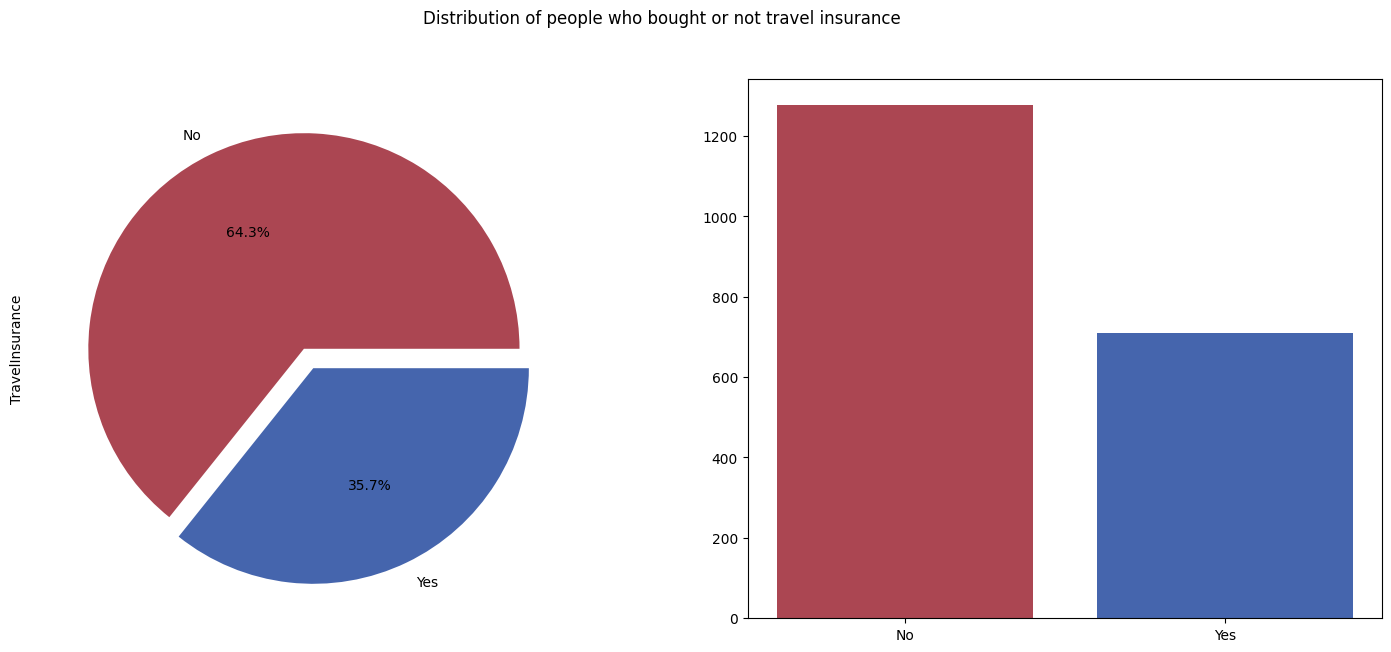

In [13]:
''' Plotting the distribution of people who bought and did not buy travel insurance '''
plot_functions.plot_pie_and_bar(
    data,
    "TravelInsurance",
    "who bought or not travel insurance",
    ["#ab4652", "#4565ad"],
)

### <a id=two2>How many graduate people have travel insurance?</a>

Since, there is a GraduateOrNot column, I wanted to see whether graduated people are more likely to buy the travel insurance.

First of all, we can see that there are more people who are not graduated in the dataset.

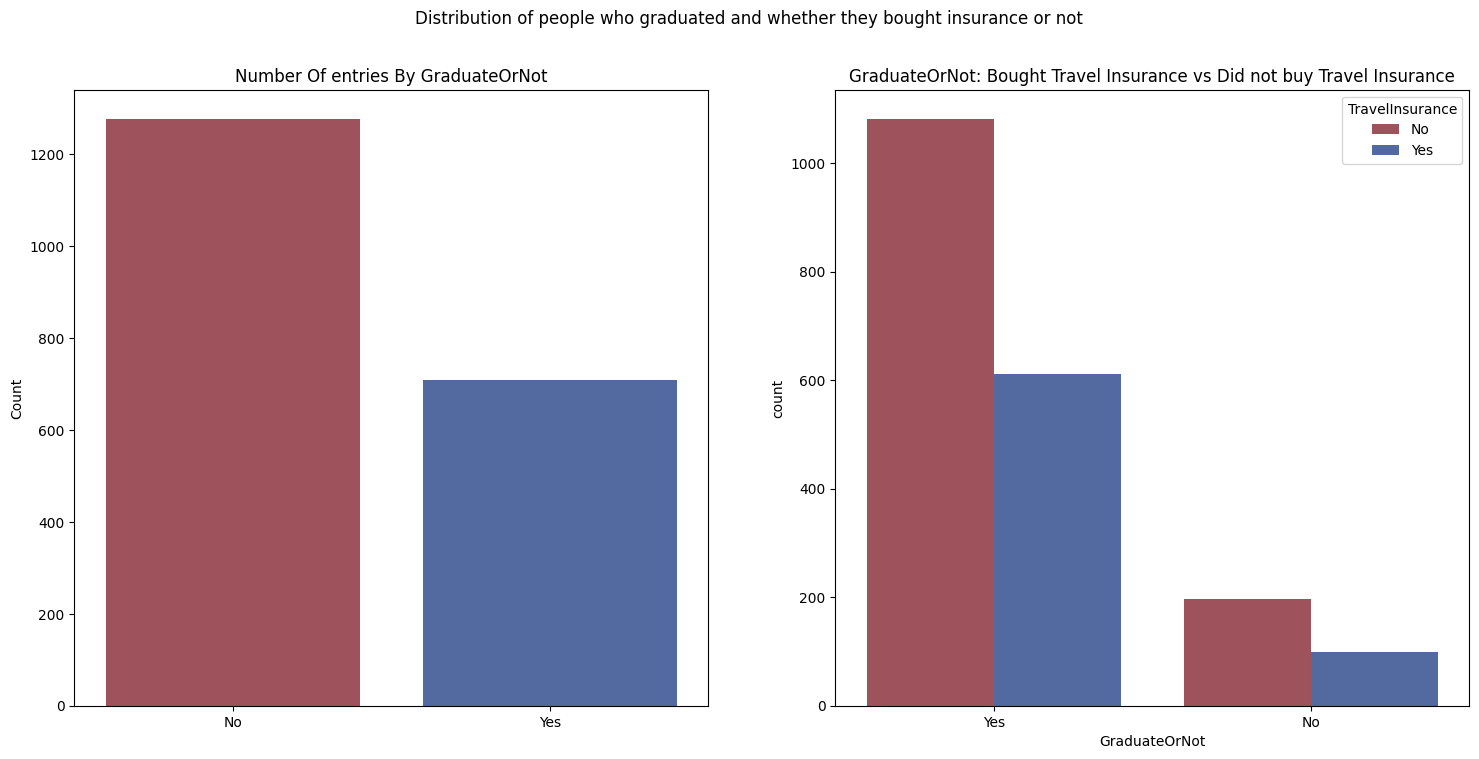

In [14]:
''' Plotting the distribution of GraduateOrNot '''
plot_functions.plot_var_with_travel_insurance(
    data, "GraduateOrNot", "Distribution of people who graduated"
)

In [15]:
''' Creating a copy for GraduateOrNot exploration '''
df_for_graduated = data.copy()
df_for_graduated["GraduateOrNot"] = data["GraduateOrNot"].map(
    {"Yes": True, "No": False}
) 

63.9% out of all graduate people did not buy travel insurance and 66.4% of people who are NOT graduate also did not buy one. 

Therefore, we say that there is not much difference for getting travel insurance whether they are graduate or not.

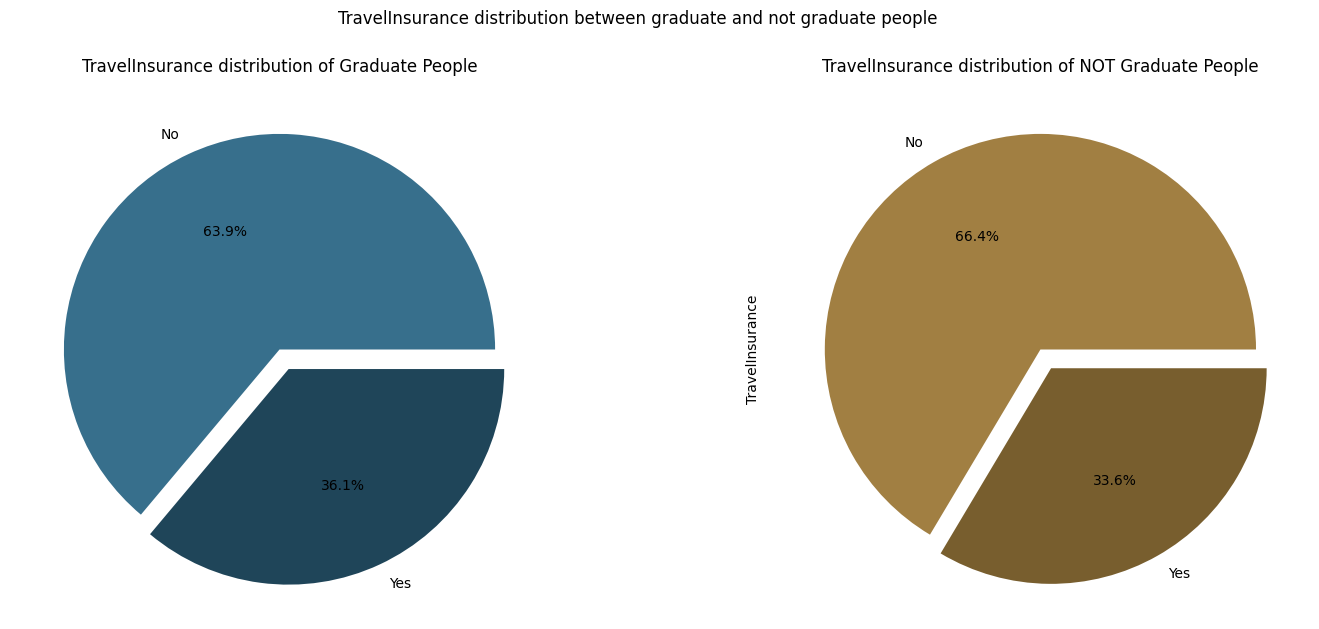

In [16]:
''' Plotting the distribution of GraduateOrNot and their choice of getting TravelInsurance '''
plot_functions.plot_two_pie_plots(
    df_for_graduated,
    "GraduateOrNot",
    "TravelInsurance",
    "Graduate People",
    "NOT Graduate People",
    "TravelInsurance distribution between graduate and not graduate people",
)

### <a id=two3>How many frequent flyers bought travel insurance?</a>

We can see that there are smaller proportion of frequent flyers in the dataset. But people who are frequent flyers, they are also more likely to get travel insurance.

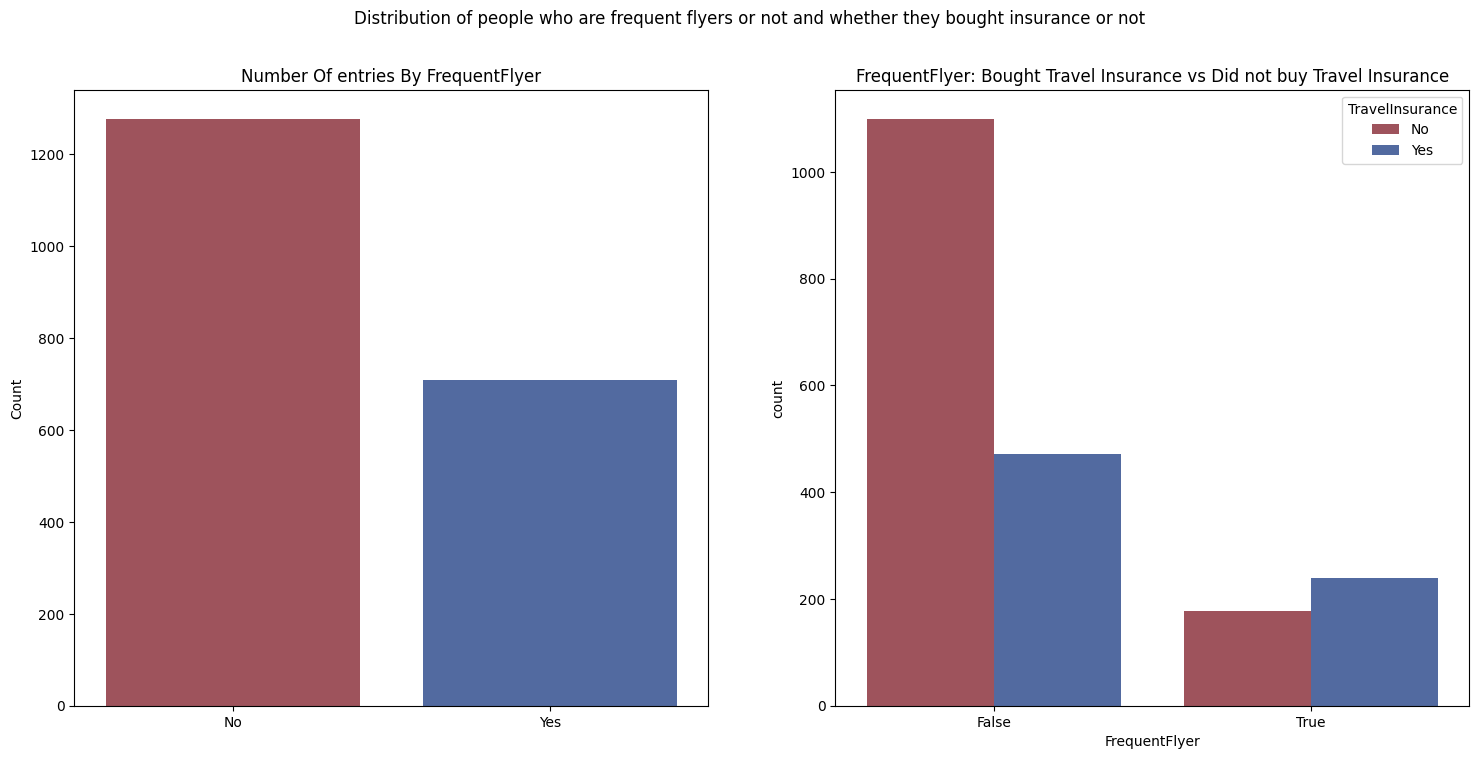

In [17]:
''' Plotting the distribution of FrequentFlyer '''
plot_functions.plot_var_with_travel_insurance(
    data, "FrequentFlyer",
    "Distribution of people who are frequent flyers or not"
)

Larger proportion (57.3%) of people who are frequently flying bought travel insurance.

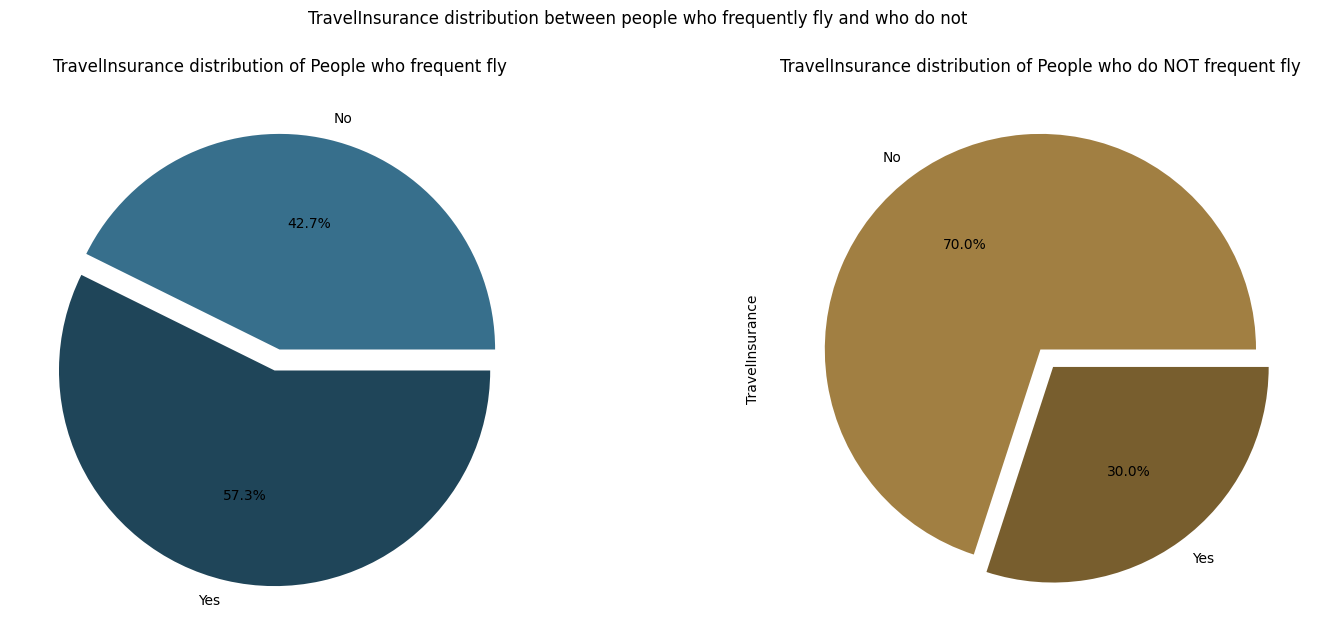

In [18]:
''' Plotting the distribution of FrequentFlyer and their choice of getting TravelInsurance '''
plot_functions.plot_two_pie_plots(
    data,
    "FrequentFlyer",
    "TravelInsurance",
    "People who frequent fly",
    "People who do NOT frequent fly",
    "TravelInsurance distribution between people who frequently fly and who do not",
)

### <a id=two4>What is age distributed and how does it impact the target variable?</a>

We can see that the largest part of the people are of age around 29.

* Oldest person was: 35 y.o.
* Youngest person was: 25 y.o.
* Average Age: 29.65 Years
* Median Age: 29 Years

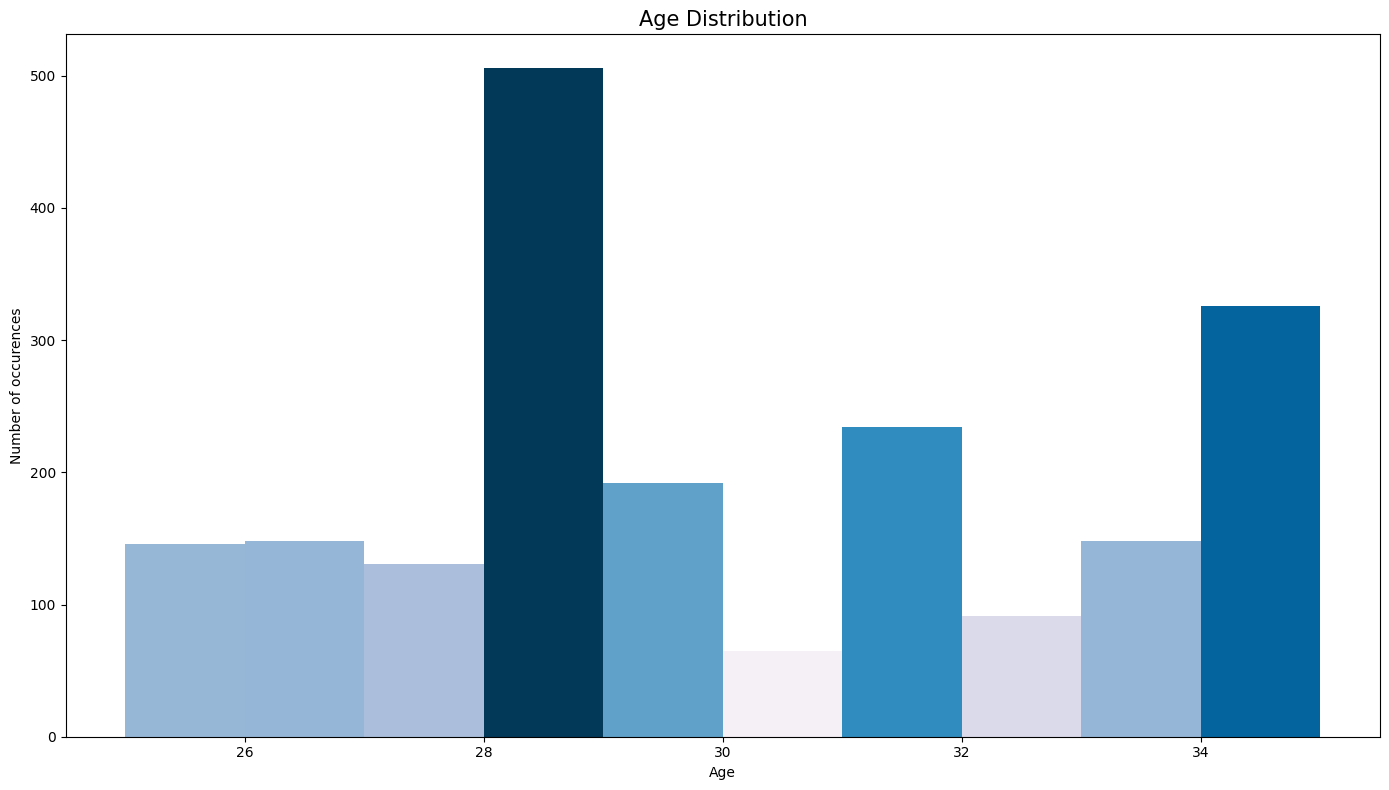

In [19]:
''' Plotting the age distribution in the dataset '''
plot_functions.plot_col_distribution(data, "Age", 10)

In [20]:
''' Printing out the oldest, youngest, average and median age '''
print("Oldest person was:", data["Age"].max(), "y.o.")
print("Youngest person was:", data["Age"].min(), "y.o.")
print("Average Age in the dataset:", round(data["Age"].mean(), 2), "Years")
print("Median Age in the dataset:", data["Age"].median(), "Years")

Oldest person was: 35 y.o.
Youngest person was: 25 y.o.
Average Age in the dataset: 29.65 Years
Median Age in the dataset: 29.0 Years


I also wanted to see the graduation status of people with different age.

* Most of the graduate people who bought TravelInsurance was around 34. And for NOT graduate people the age was around 30.  
* Most of the graduate people who did NOT buy TravelInsurance were of age 28. And for NOT graduate people the age was around 31.


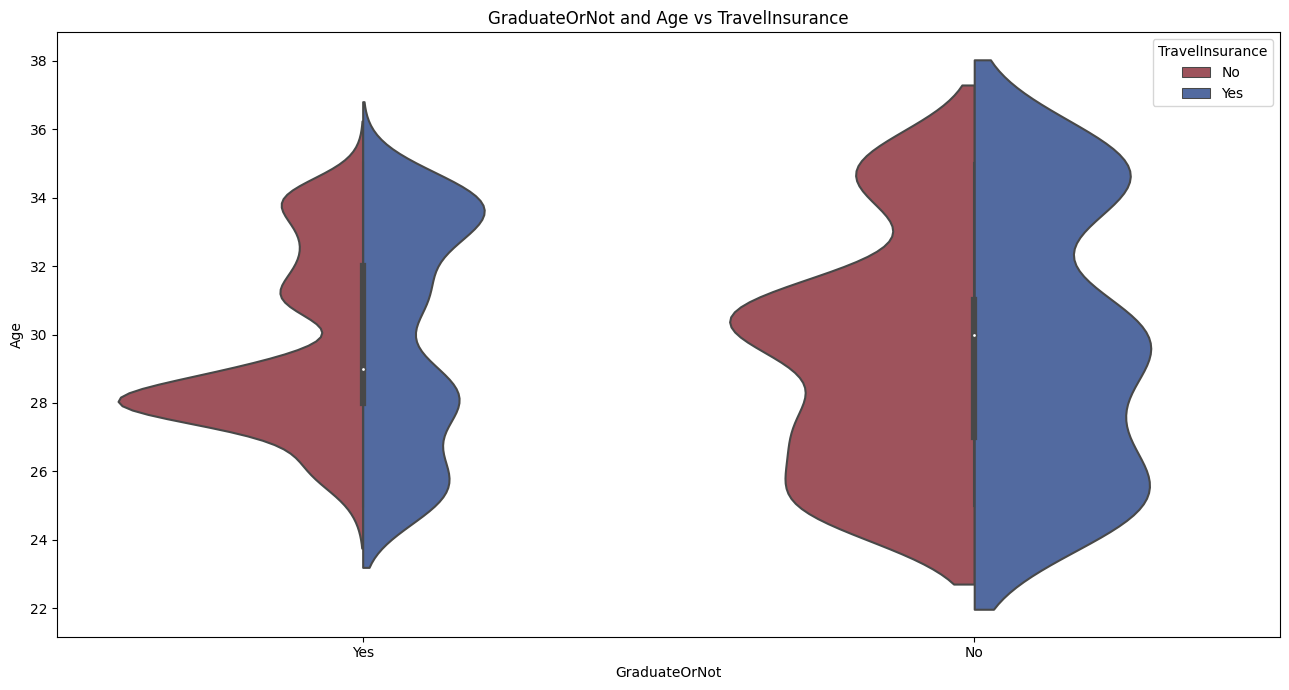

In [21]:
''' Plotting violin plot for GraduateOrNot and their Age and TravelInsurance distribution '''
plot_functions.plot_violin_plot_with_hue(
    data, "GraduateOrNot", "Age", "TravelInsurance"
)

I also wanted to see how frequent are people of different ages flying.

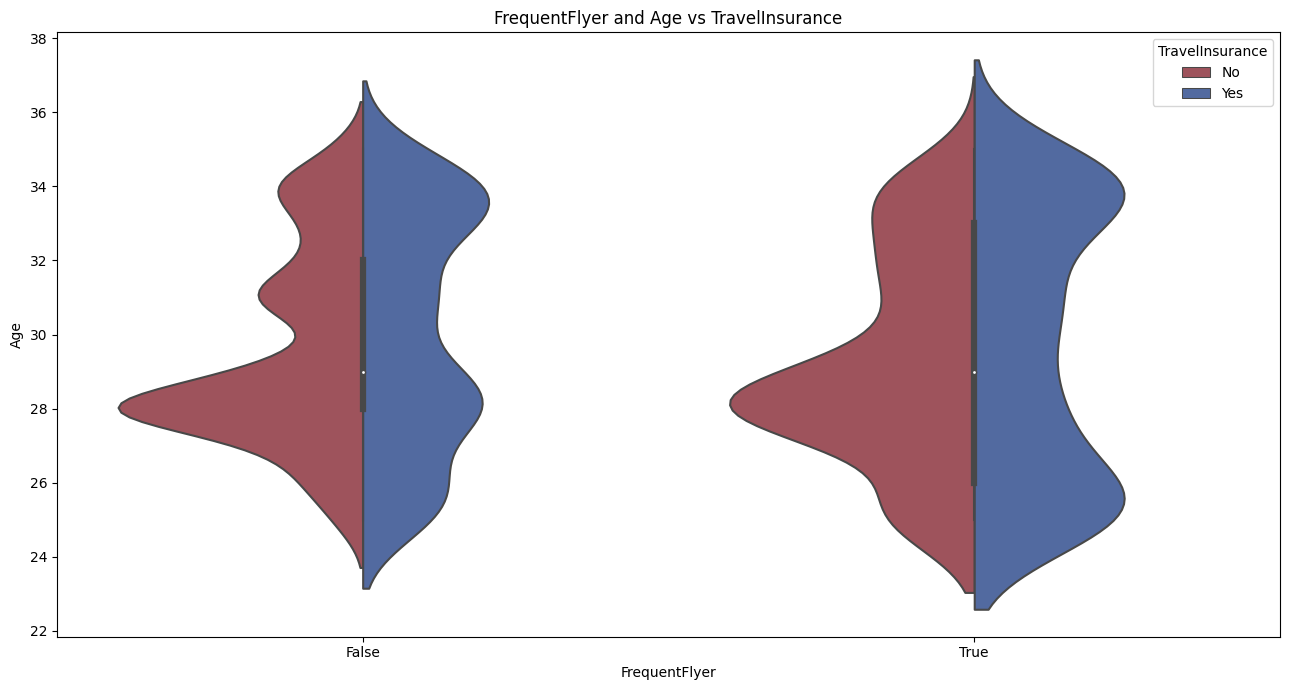

In [22]:
''' Plotting violin plot for FrequentFlyer and their Age and TravelInsurance distribution '''
plot_functions.plot_violin_plot_with_hue(
    data, "FrequentFlyer", "Age", "TravelInsurance"
)

All in all, we can see that the most frequent age for people who did not buy travel insurance was around 29 and around 35 for people who bought travel insurance.

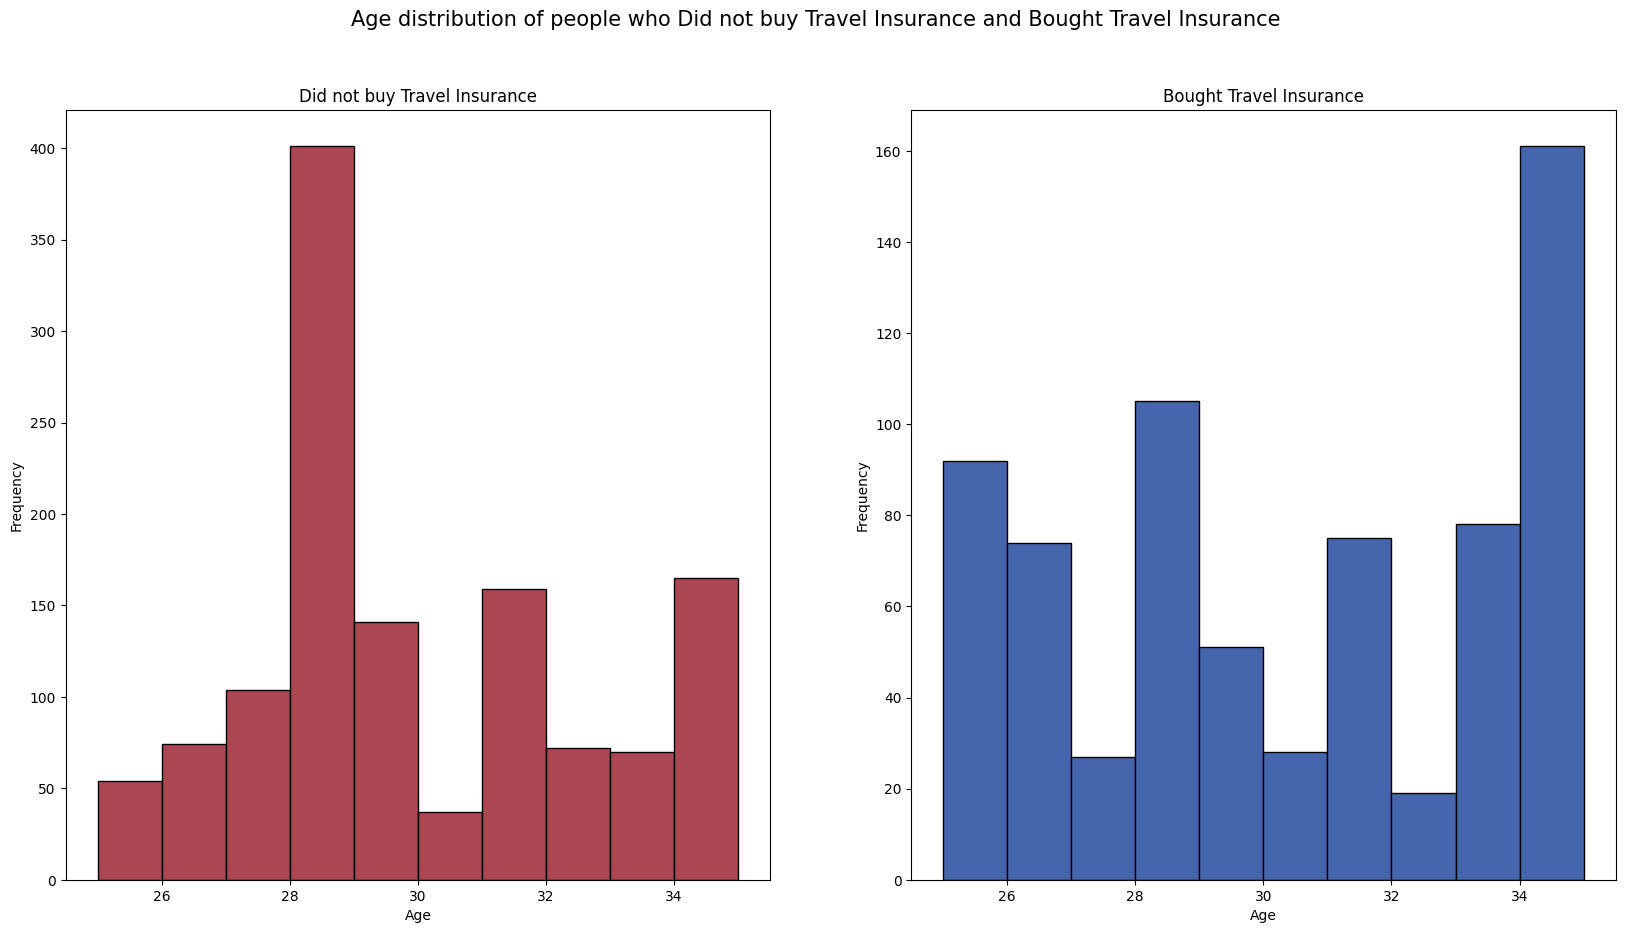

In [23]:
''' Plotting Age distribution of people who bought and did not buy travel insurance'''
plot_functions.plot_two_histograms(
    data[data["TravelInsurance"] == "No"],
    data[data["TravelInsurance"] == "Yes"],
    "Age",
    "Did not buy Travel Insurance",
    "Bought Travel Insurance",
)

But I also wanted to perform a test to see whether there is a significant difference between people who have travel insurance and who do not.

#### <a id=two41>Is there a significant difference between age for people who bought and did not buy travel insurance?</a>


##### **Hypothesis testing** 

Considering people who bought and did not buy travel insurance, is there a significant difference between their age?

Let's define a few parameters:
Population here sample of 200 entries who bought travel insurance and 200 who did not.
Our Parameter of Interest is (μ1 − μ2): age difference.
* μ1: Mean age of people who bought travel insurance
* μ2: Mean age of people who did NOT buy travel insurance
* H₀: μ1==μ2
* H₁: μ1!=μ2

Significance Level - 5%

In [24]:
''' Getting sample of 200 people who bought travel insurance '''
bought_TI = data[data["TravelInsurance"] == "Yes"].sample(200)

''' Getting sample of 200 people who did not buy travel insurance '''
not_buy_TI = data[data["TravelInsurance"] == "No"].sample(200)

In [25]:
''' Getting z-test results '''
_, p_val = ztest(bought_TI["Age"], not_buy_TI["Age"], value=0)

if p_val > 0.05:
    print(
        "Failed to reject null hypothesis: there is no significant Age difference",
        "between people who bought and who did not buy travel insurance."
    )

Failed to reject null hypothesis: there is no significant Age difference between people who bought and who did not buy travel insurance.


### <a id=two5>Which families are more likely to buy travel insurance?</a>

First I wanted to see the overall situation in the dataset and how many family members each entry has.

We can see that the most of the families have 4 members in it. Then it's 5 and 3 members.

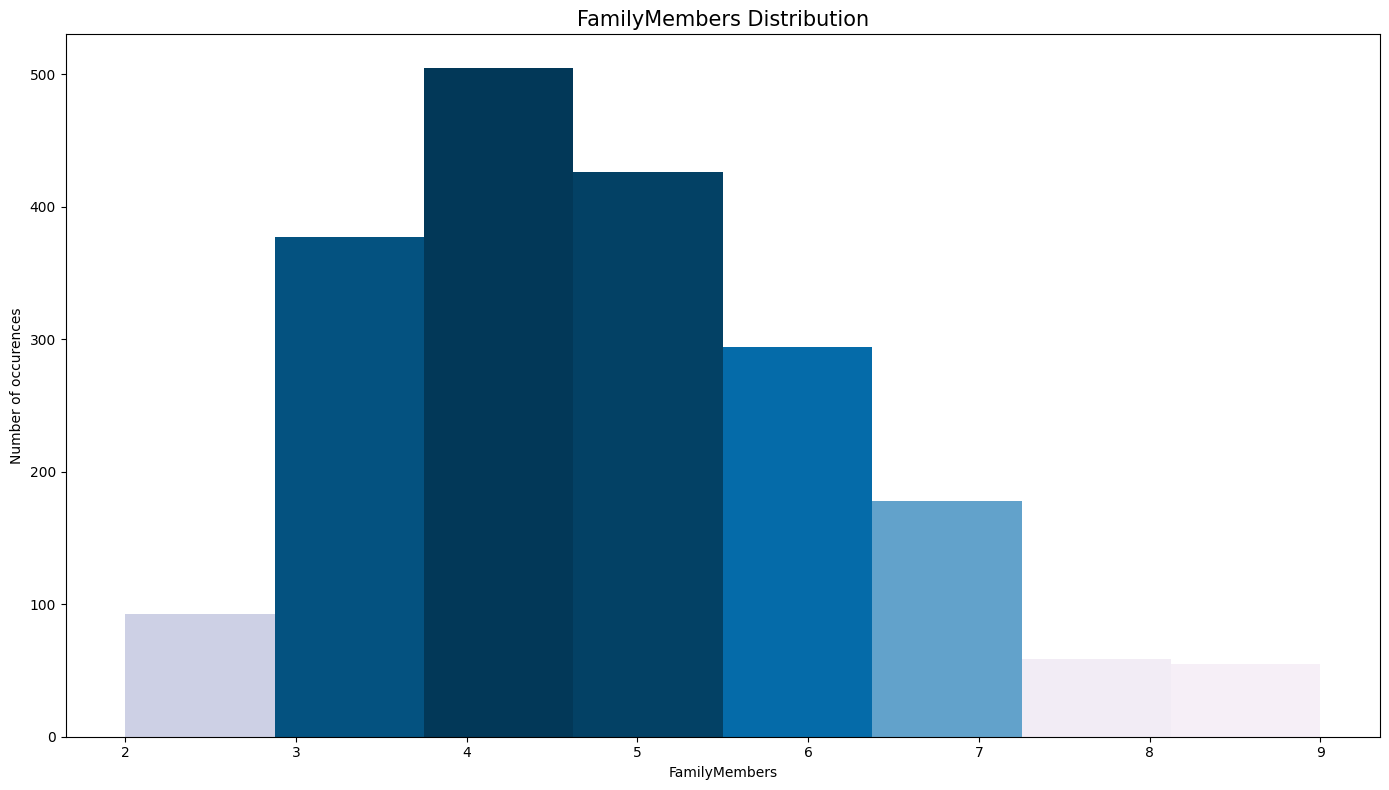

In [26]:
''' Plotting FamilyMembers distribution in histogram '''
plot_functions.plot_col_distribution(data, "FamilyMembers", 8)

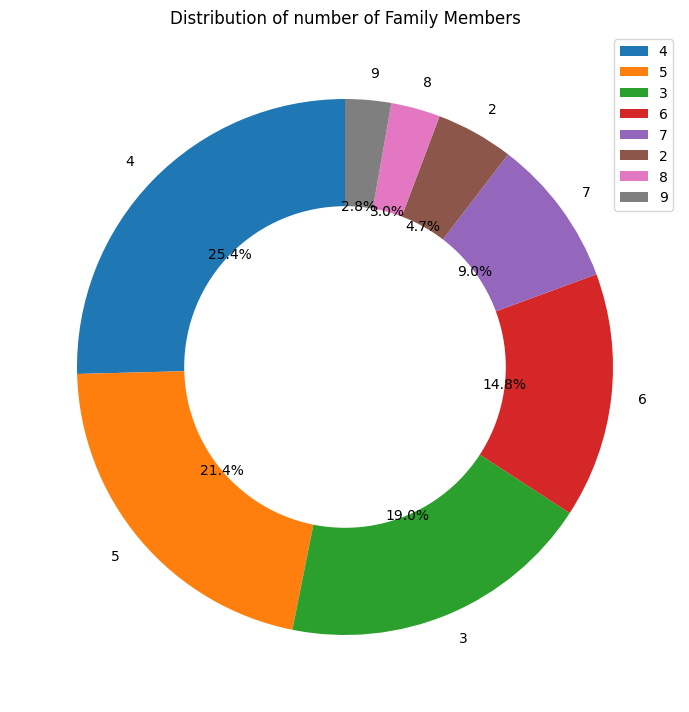

In [27]:
''' Plotting FamilyMembers distribution in pie plot '''
plot_functions.plot_pie_plot_circle(data["FamilyMembers"], "Family Members")

I created a new feature called LargeFamily which is a boolean value for those entries that have FamilyMembers more than 5.

There are more smaller families than large overall:
* There are 586 (29.49%) large families and 1401 (70.51%) smaller ones in the dataset.

In [28]:
''' Creating a new feature LargeFamily which takes all entries where FamilyMembers is greater than 5 '''
data["LargeFamily"] = data["FamilyMembers"] > 5

In [29]:
''' Taking large and small families and printing the number of each in the dataset '''
large_families = len(data[data["LargeFamily"]])
smaller_families = len(data) - large_families
print(f"There are {large_families} ({round(large_families/len(data)*100,2)}%)",
      f"large families and {smaller_families} ({round(smaller_families/len(data)*100,2)}%) smaller ones in the dataset.")

There are 586 (29.49%) large families and 1401 (70.51%) smaller ones in the dataset.


We can see that people in large families are more likely to buy travel insurance as we can see 43.9% of them bought and 32.3% of smaller families did not buy travel insurance.

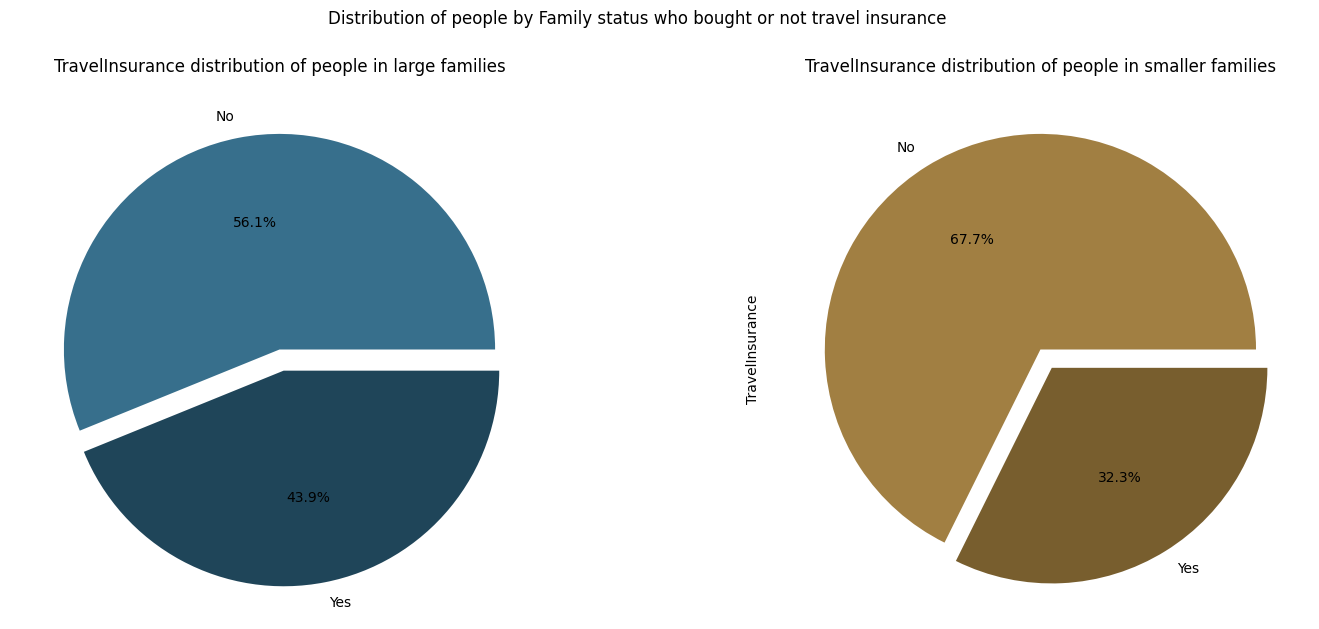

In [30]:
''' Plotting TravelInsurance choice in large and small families '''
plot_functions.plot_two_pie_plots(
    data,
    "LargeFamily",
    "TravelInsurance",
    "people in large families",
    "people in smaller families",
    "Distribution of people by Family status who bought or not travel insurance",
)

### <a id=two6>What is the distribution of income in the dataset and how it is related to buying travel insurance?</a>

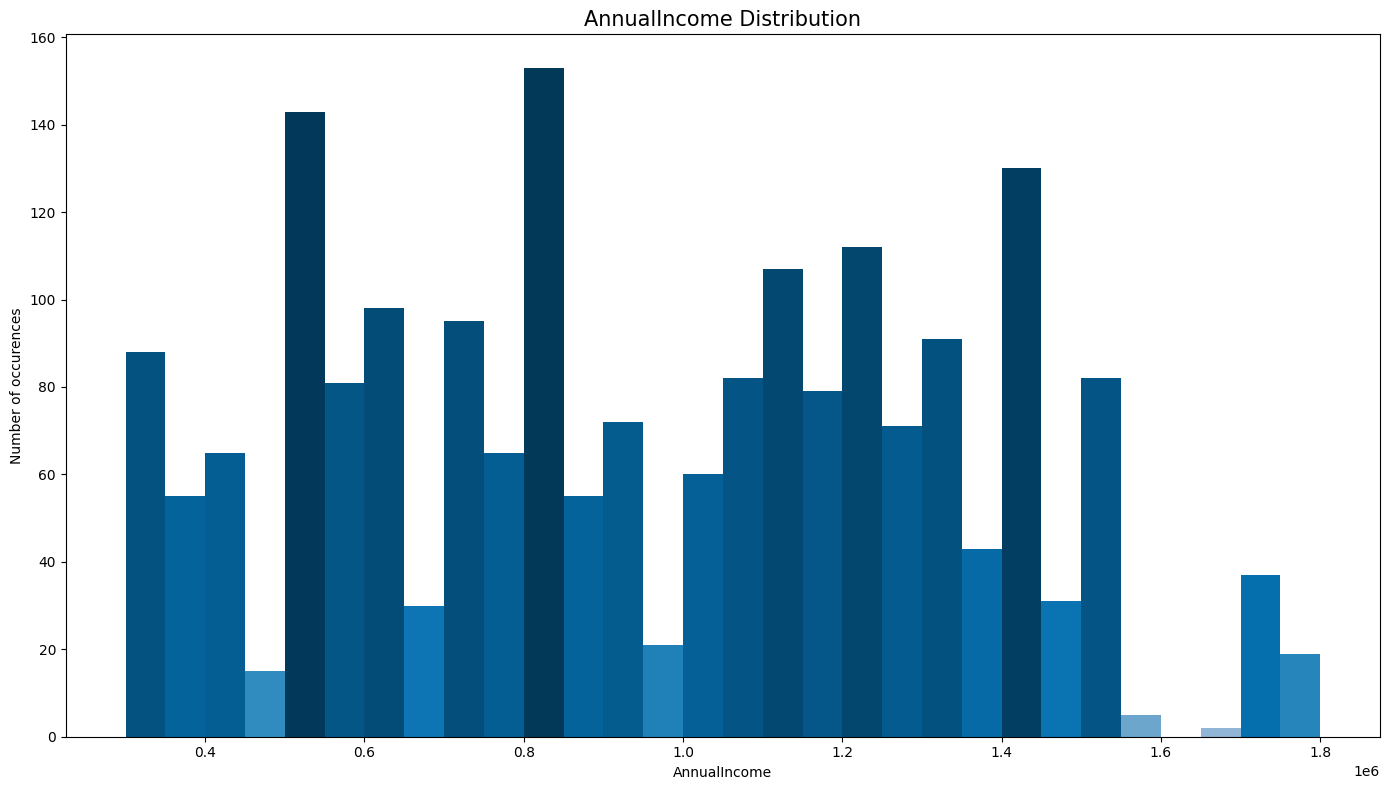

In [31]:
''' Plotting AnnualIncome distribution in the dataset '''
plot_functions.plot_col_distribution(data, "AnnualIncome", 30)

I took entries that are higher than median and lower than median and compared whether they bought or did not buy travel insurance.

* 47.9% of people whose income is higher than median bought travel insurance
* And only 22.3% of people whose income is lower than median bought travel insurance.

In [32]:
''' Creating a new feature called HighIncome which takes entries which have AnnualIncome higher than median'''
high_income = np.percentile(data["AnnualIncome"], 50)
data["HighIncome"] = data["AnnualIncome"] >= high_income

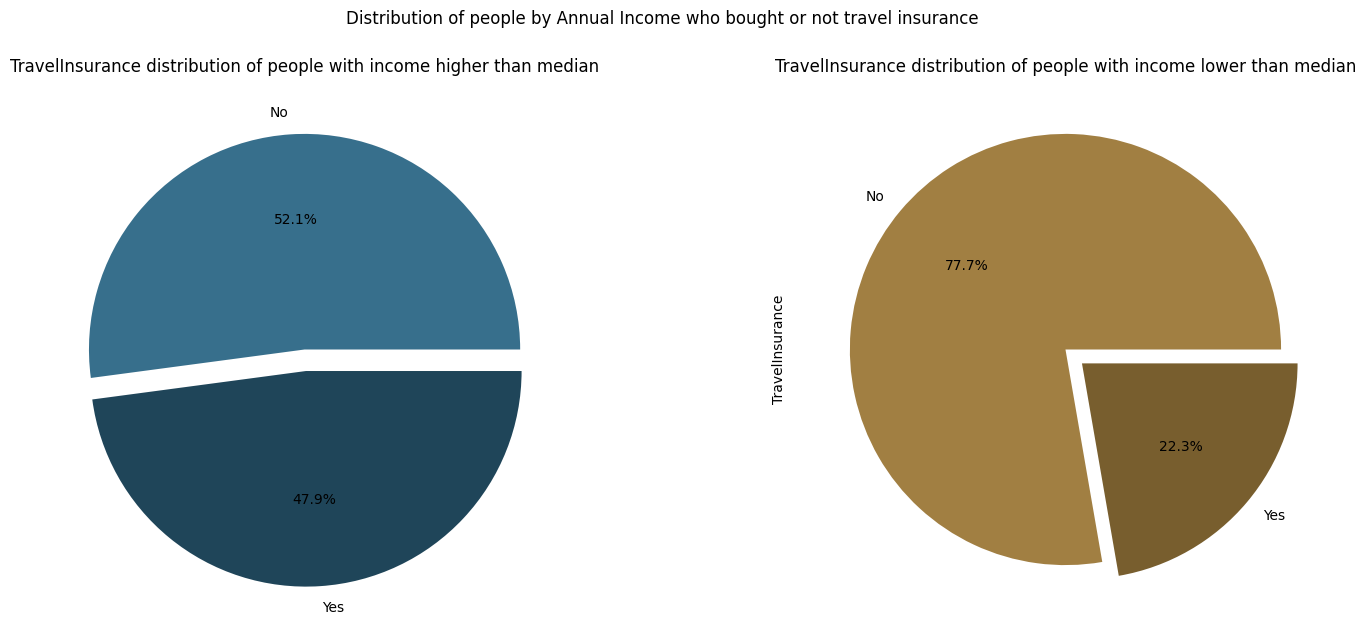

In [33]:
''' Plotting TravelInsurance choice for people which higher and lower AnnualIncome than median '''
plot_functions.plot_two_pie_plots(
    data,
    "HighIncome",
    "TravelInsurance",
    "people with income higher than median",
    "people with income lower than median",
    "Distribution of people by Annual Income who bought or not travel insurance",
)

### <a id=two7>Are people which chronic diseases more likely to buy travel insurance?</a>

We can see that there is no strong difference between people with or without chronic diseases.

* 37.1% of people with chronic diseases bought travel insurance.
* 35.2% of people without chronic diseases bought travel insurance.

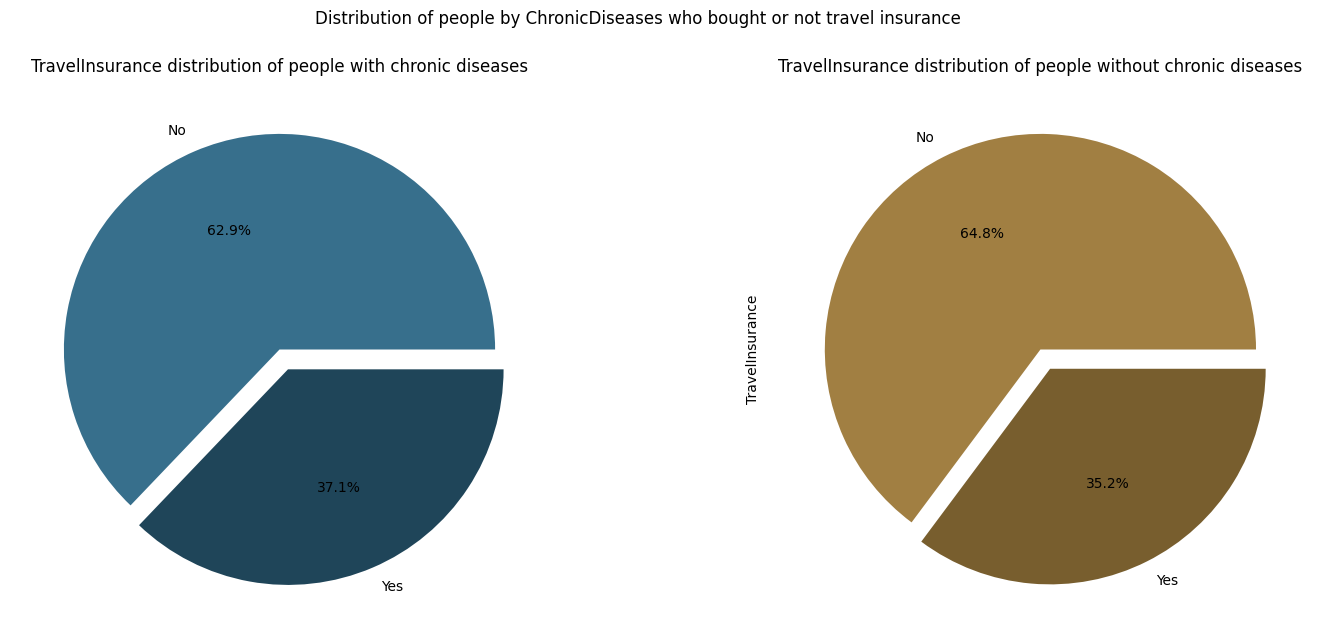

In [34]:
''' Plotting TravelInsurance choice for people who have and do not have chronic disease '''
plot_functions.plot_two_pie_plots(
    data,
    "ChronicDiseases",
    "TravelInsurance",
    "people with chronic diseases",
    "people without chronic diseases",
    "Distribution of people by ChronicDiseases who bought or not travel insurance",
)

### <a id=two8>Are people who ever travelled abroad also are more likely to buy travel insurance?</a>

We can see that there a huge difference between people who ever travelled abroad.

* 78.4% of people who ever travelled abroad also bought travel insurance.
* Only 25.6% of people who have never travelled abroad bought travel insurance.

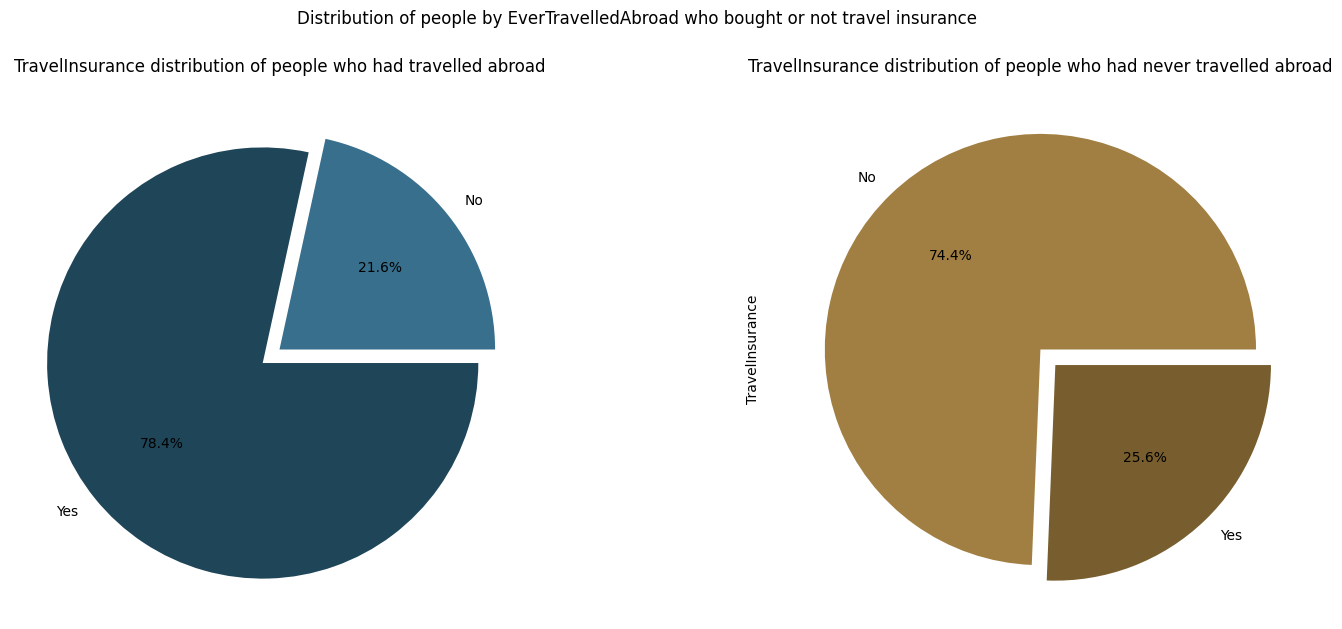

In [35]:
''' Plotting TravelInsurance choice for people who had and have never ever travelled abroad '''
plot_functions.plot_two_pie_plots(
    data,
    "EverTravelledAbroad",
    "TravelInsurance",
    "people who had travelled abroad",
    "people who had never travelled abroad",
    "Distribution of people by EverTravelledAbroad who bought or not travel insurance",
)

### <a id=two9>Does employment type impact the choice of buying travel insurance?</a>

First, of all I wanted to see the distribution of different employment types. There are more people (71.3%) who work in a private section than those who work in government sector.

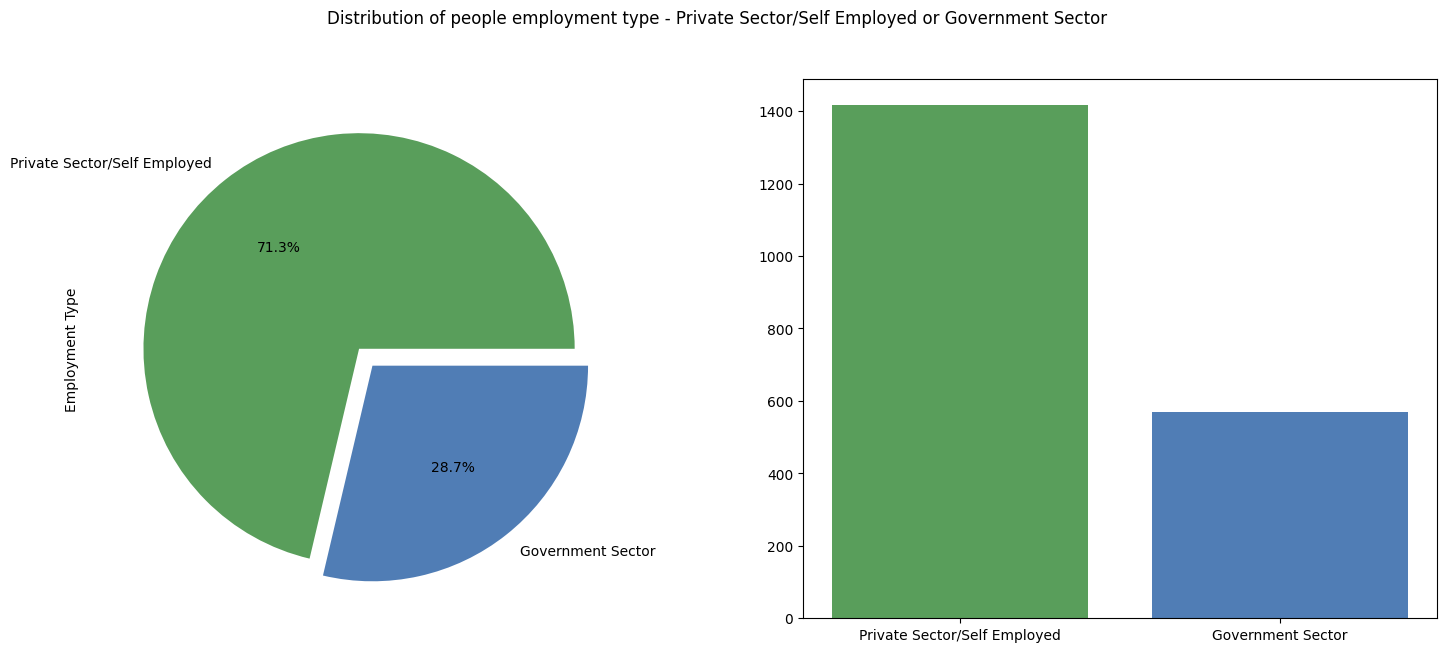

In [36]:
''' Plotting distribution of people employment type in the dataset '''
plot_functions.plot_pie_and_bar(
    data,
    "Employment Type",
    "employment type - Private Sector/Self Employed or Government Sector",
    ["#599e5b", "#507db5"],
)

* People in government sector are less likely to buy travel insurance - 24.6% of them bought and 75.4% did not.
* 40.2% of people in private sector bought travel insurance.

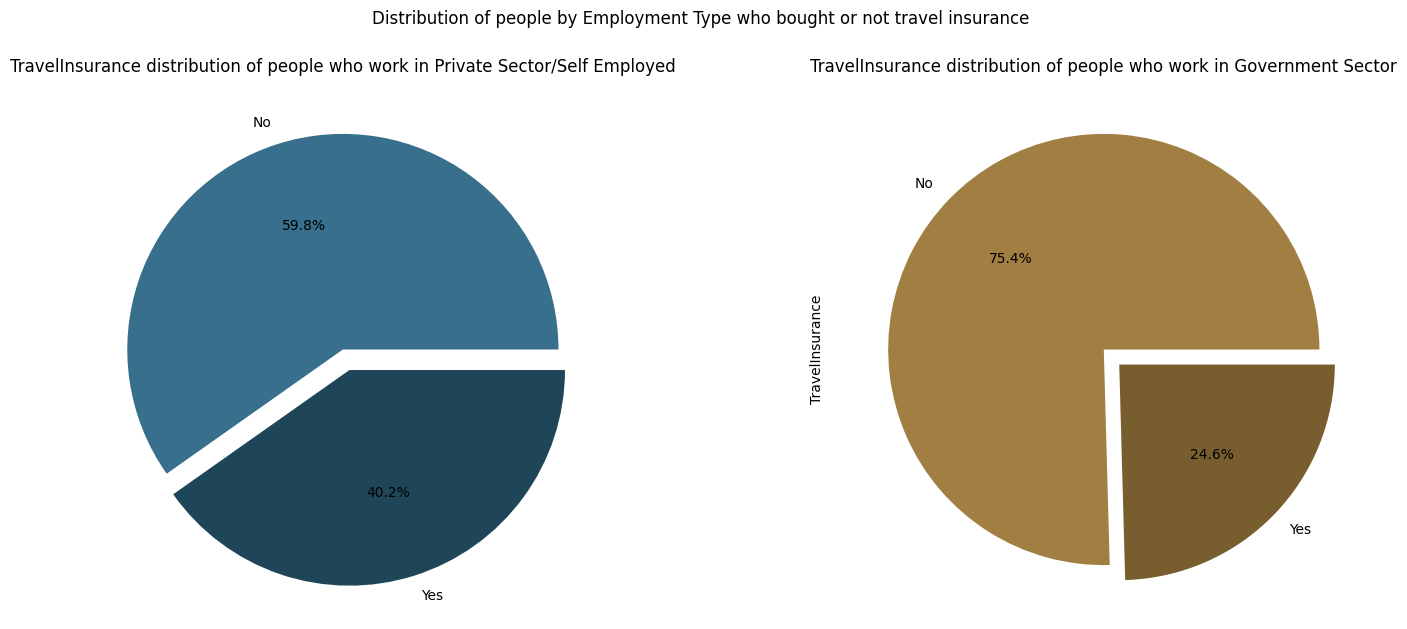

In [37]:
''' Plotting TravelInsurance choice for people who work in private or public sectors '''
data["Employment Type"] = data["Employment Type"].map(
    {"Private Sector/Self Employed": True, "Government Sector": False}
)
plot_functions.plot_two_pie_plots(
    data,
    "Employment Type",
    "TravelInsurance",
    "people who work in Private Sector/Self Employed",
    "people who work in Government Sector",
    "Distribution of people by Employment Type who bought or not travel insurance",
)

Of course, this choice might be impacted by different incomes as well. Therefore I wanted to see whether people in private sector earn more money than people in government sector.
 
#### <a id=two91>Do people in private sector earn more than ones in government sector?</a>

Mean AnnualIncome in private sector: 1016196.19, AnnualIncome median in private sector: 1050000.0
Mean AnnualIncome in public sector: 725350.88, AnnualIncome median in public sector: 700000.0


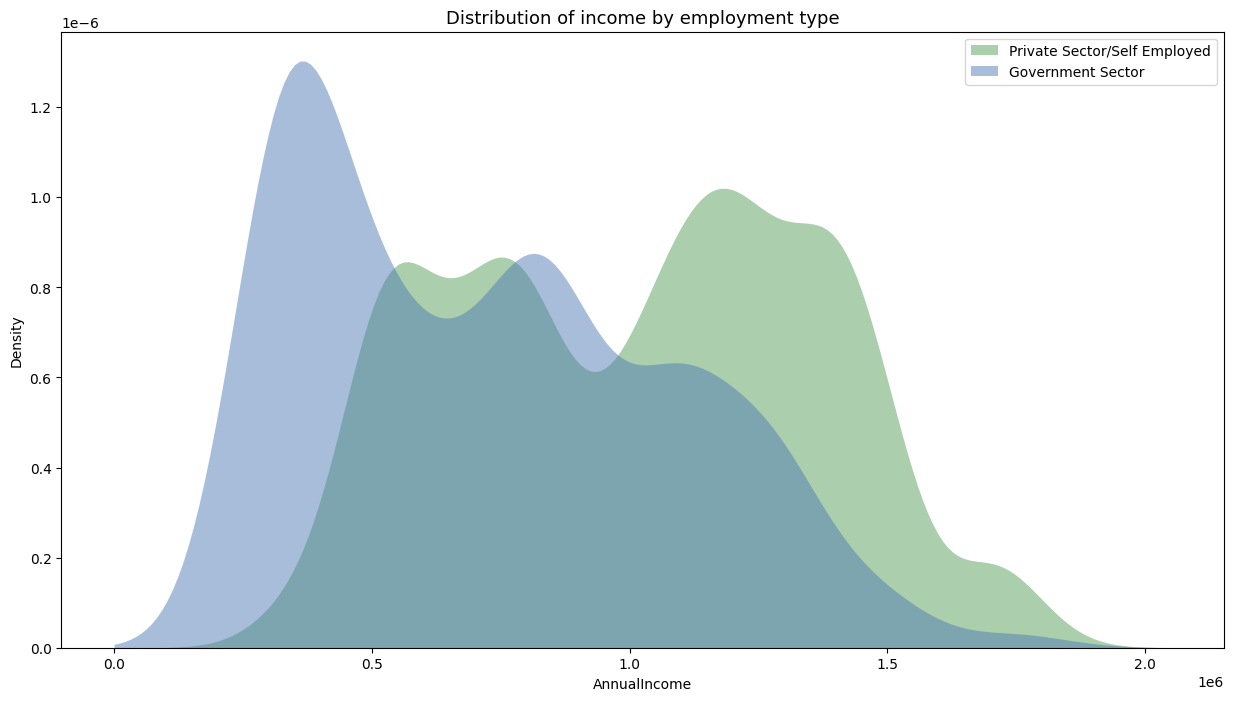

In [38]:
''' Plotting Annual Income distribution for people who work in public or private sectors '''
private_sector = data[data["Employment Type"] == True]
public_sector = data[data["Employment Type"] == False]
print(
    f"Mean AnnualIncome in private sector: {round(private_sector['AnnualIncome'].mean(), 2)},",
    f"AnnualIncome median in private sector: {private_sector['AnnualIncome'].median()}"
)
print(
    f"Mean AnnualIncome in public sector: {round(public_sector['AnnualIncome'].mean(), 2)},",
    f"AnnualIncome median in public sector: {public_sector['AnnualIncome'].median()}"
)
plot_functions.plot_kde_plot(
    private_sector,
    public_sector,
    "AnnualIncome",
    "Private Sector/Self Employed",
    "Government Sector",
    "income by employment type",
)

##### **Hypothesis testing** 

Considering people who work in private and public sectors, is there a significant difference between their annual income?

Let's define a few parameters:
Population here sample of 200 entries who work in private sector and 200 who work in public.
Our Parameter of Interest is (μ1 − μ2): annual income difference.
* μ1: Mean age of people who bought travel insurance
* μ2: Mean age of people who did NOT buy travel insurance
* H₀: μ1!=μ2
* H₁: μ1==μ2

Significance Level - 5%

In [39]:
''' Getting z-test results '''
private_sector = private_sector.sample(200)
public_sector = public_sector.sample(200)

_, p_val = ztest(private_sector["AnnualIncome"], public_sector["AnnualIncome"], value=0)

if p_val > 0.05:
    print(
        "Failed to reject null hypothesis: there is no significant AnnualIncome",
        "difference between people who bought and who did not buy travel insurance."
    )
else:
    print(
        f"The null hypothesis is rejected: ({p_val} < 5%) there is a statistically significant",
        "difference in AnnualIncome between people who bought and who did not buy travel insurance."
    )

The null hypothesis is rejected: (7.955340887248275e-16 < 5%) there is a statistically significant difference in AnnualIncome between people who bought and who did not buy travel insurance.


## <a id=feature_analysis>Feature Analysis</a>

In [40]:
''' Creating a copy for feature analysis '''
df = data.copy()

First, I will encode all binary categorical values to numerical 0 and 1.

In [41]:
''' Converting values into binary 0 and 1s '''
df["GraduateOrNot"] = df["GraduateOrNot"].map({"Yes": 1, "No": 0})
df["ChronicDiseases"] = df["ChronicDiseases"].map({True: 1, False: 0})
df["FrequentFlyer"] = df["FrequentFlyer"].map({True: 1, False: 0})
df["EverTravelledAbroad"] = df["EverTravelledAbroad"].map({True: 1, False: 0})
df["LargeFamily"] = df["LargeFamily"].map({True: 1, False: 0})
df["HighIncome"] = df["HighIncome"].map({True: 1, False: 0})
df["Employment Type"] = df["Employment Type"].map({True: 1, False: 0})
df["TravelInsurance"] = df["TravelInsurance"].map({"Yes": 1, "No": 0})
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,LargeFamily,HighIncome
0,31,0,1,400000,6,1,0,0,0,1,0
1,31,1,1,1250000,7,0,0,0,0,1,1
2,34,1,1,500000,4,1,0,0,1,0,0
3,28,1,1,700000,3,1,0,0,0,0,0
4,28,1,1,700000,8,1,1,0,0,1,0


### <a id=three1>Feature Correlation Analysis</a>

Then, I plot the correlation heatmap to see which features are strongest correlated.

Positively:
* EverTravelledAbroad and AnnualIncome with correlation of 0.486043
* FrequentFlyer and AnnualIncome with correlation of 0.353087

Negatively:
* FrequentFlyer and ChronicDiseases of -0.043720 but this value is not strong and almost equal to 0.


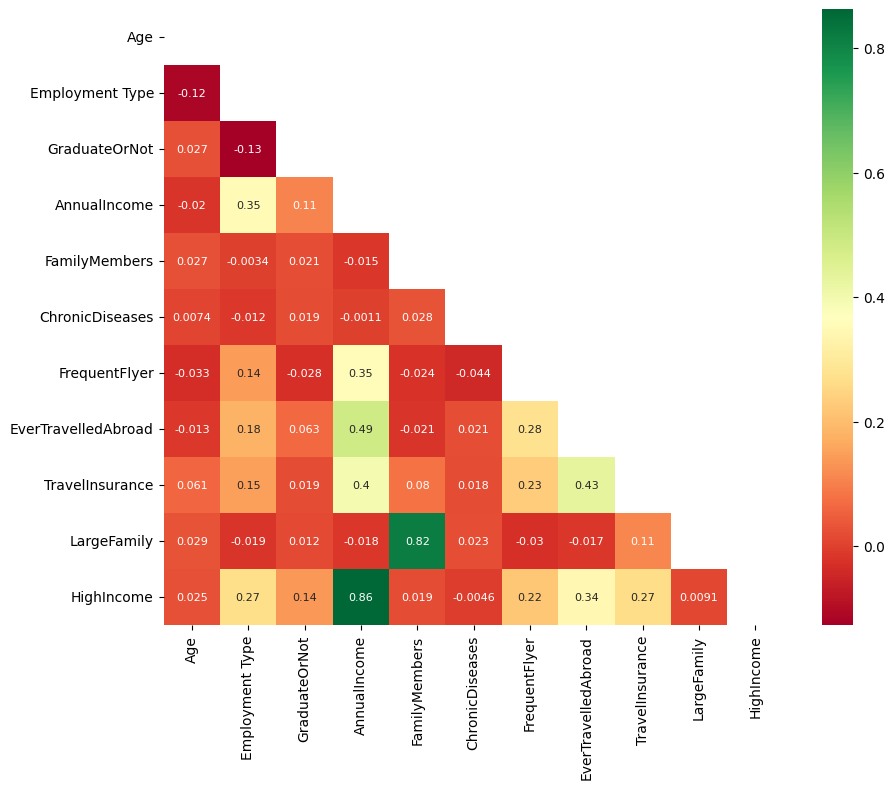

In [42]:
''' Plotting heatmap for feature correlations '''
cols = list(df._get_numeric_data().columns)
plot_functions.plot_heatmap(df, cols)

Since, the goal of this project is to predict TravelInsurance, I wanted to see which features are strongest correlated with it.

* We can see that feature EverTravelledAbroad and AnnualIncome are the strongest correlated.

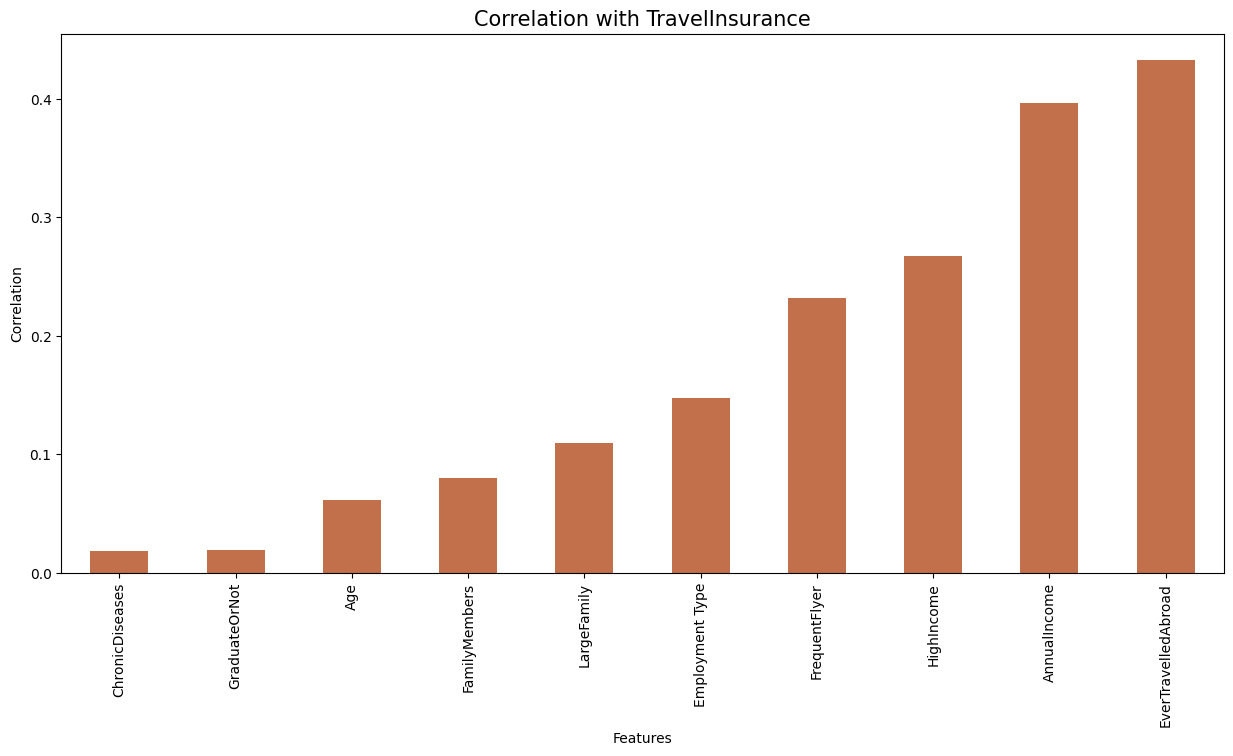

In [43]:
''' Plotting correlations of different features with TravelInsurance '''
plot_functions.plot_feature_correlation_with(df[cols], "TravelInsurance")

### <a id=three2>Feature Engineering</a>

Now, I will fix existing values to be usable for prediction.

Since age is age is continuous value, I will split it into 4 categories where:

* Age <=27 - category 0
* Age > 27 and Age <= 30 - category 1
* Age 30 and Age <= 33 - category 2
* Age 33 - category 3

In [44]:
''' Taking data with only chosen features '''
data = df[cols]

In [45]:
''' Converting continuous Age value into 4 categories '''
data["ageCategorized"] = data["Age"].apply(
    lambda age: 0 if age <= 27 else 1
    if age <= 30 else 2 if age <= 33 else 3
)
data.head(2)

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,LargeFamily,HighIncome,ageCategorized
0,31,0,1,400000,6,1,0,0,0,1,0,2
1,31,1,1,1250000,7,0,0,0,0,1,1,2


Same for AnnualIncome, this value had to be split into 10 certain categories.

In [46]:
''' Converting continuous AnnualIncome value into 10 categories '''
def income_categorize(income):
    if income <= 400000:
        return 0
    elif income <= 550000:
        return 1
    elif income <= 700000:
        return 2
    elif income <= 850000:
        return 3
    elif income <= 1000000:
        return 4
    elif income <= 1150000:
        return 5
    elif income <= 1300000:
        return 6
    elif income <= 1450000:
        return 7
    elif income <= 1650000:
        return 8
    else:
        return 9

data["incomeCategorized"] = data["AnnualIncome"].apply(income_categorize)
data.head(2)

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,LargeFamily,HighIncome,ageCategorized,incomeCategorized
0,31,0,1,400000,6,1,0,0,0,1,0,2,0
1,31,1,1,1250000,7,0,0,0,0,1,1,2,6


* Chosen Features *

Final set of features was chosen. Most of them are binary values but annual income and age converted into categories has to be furtherly encoded with one-hot encoding.

* GraduateOrNot
* AnnualIncome
* FamilyMembers
* ChronicDiseases
* FrequentFlyer
* EverTravelledAbroad
* TravelInsurance
* LargeFamily
* HighIncome
* Employment Type
* Annual income categories
* Age categories

In [47]:
''' Priting out finaly set of features that will be used for prediction '''
cols = list(data._get_numeric_data().columns)
cols.remove("Age")
cols.remove("AnnualIncome") 
print("Final set of features:")
for col in cols:
    print(col)

Final set of features:
Employment Type
GraduateOrNot
FamilyMembers
ChronicDiseases
FrequentFlyer
EverTravelledAbroad
TravelInsurance
LargeFamily
HighIncome
ageCategorized
incomeCategorized


### <a id=three3>One Hot Encoding</a>

Now I encode age, income and family members values with one hot encoding approach. After this, out whole dataset has either 0 or 1 value which is good for prediction!

In [48]:
''' Taking copy of dataset with final features '''
data_encoded = data[cols].copy()

In [49]:
''' Encoding Age, AnualIncome and FamilyMembers with one hot encoding '''
encoder = OneHotEncoder(handle_unknown="ignore")
cols = ["ageCategorized", "incomeCategorized", "FamilyMembers"]
for col in cols:
    encoder_df = encoder.fit_transform(data_encoded[[col]]).toarray()
    encoder_df = pd.DataFrame(encoder_df, columns=[f"{col}_{i}" for i in range(encoder_df.shape[1])])
    data_encoded = data_encoded.join(encoder_df).drop(col, axis=1)
data_encoded

,Employment Type,GraduateOrNot,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,LargeFamily,HighIncome,ageCategorized_0,ageCategorized_1,...,incomeCategorized_8,incomeCategorized_9,FamilyMembers_0,FamilyMembers_1,FamilyMembers_2,FamilyMembers_3,FamilyMembers_4,FamilyMembers_5,FamilyMembers_6,FamilyMembers_7
0,0,1,1,0,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1,0,0,0,0,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,1,1,0,0,1,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,1,1,0,0,0,0,0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,1,1,0,0,1,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1982,1,1,0,1,1,1,0,1,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1983,1,1,1,0,1,0,0,1,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1984,1,1,1,0,0,0,1,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1985,1,1,0,1,1,1,1,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## <a id=prediction1>Prediction Phase with selected models</a>

Finally, I can start prediction phase. I decided to use these several models:

* K-Nearest Neighbors
* Support Vector Machines
* Decision Tree Classifiers/Random Forests
* Naive Bayes
* Linear Discriminant Analysis
* Logistic Regression



In [50]:
''' Created variable for prediction '''
df_pred = data_encoded

In [51]:
''' Removing target variable from features '''
features = [col for col in df_pred.columns if col != "TravelInsurance"]

First, I need to split data into train and test samples. I tool 80% for train and 20% for test by using StratifiedShuffleSplit to have the same distributions in both train and test samples.

In [52]:
''' Performing stratified shuffle split '''
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_pred, df_pred["TravelInsurance"]):
    train = df_pred.loc[train_index]
    test = df_pred.loc[test_index]

In [53]:
''' Splitting data into training and testing '''
X_train = train[features]
Y_train = train["TravelInsurance"]
X_test = test[features]
Y_test = test["TravelInsurance"]

Now, I will perform cross validation for each model to see what results I get.

Since this is classification, I will use cross validation mean to see which scores highest.

In [54]:
''' Performing cross validation for all chosen models and taking their results into a dataframe "results" '''
''' Performing cross validation for all chosen models and taking their results into a dataframe "results" '''
kfold = KFold(n_splits=10, random_state=22, shuffle=True)

classifiers = [
    "SVM",
    "Logistic Regression",
    "KNN",
    "Decision Tree",
    "Naive Bayes",
    "Random Forest",
]
models = [
    svm.SVC(probability=True),
    LogisticRegression(),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    GaussianNB(),
    RandomForestClassifier(),
]

results = pd.DataFrame(columns=["CV Accuracy Mean"], index=classifiers)

for i, model in enumerate(models):
    cv_result = cross_val_score(model, X_train, Y_train, cv=kfold, scoring="accuracy")
    results.loc[classifiers[i]] = [cv_result.mean()]

results.sort_values(by="CV Accuracy Mean", ascending=False)

,CV Accuracy Mean
SVM,0.828218
Logistic Regression,0.816257
Random Forest,0.787911
KNN,0.787302
Naive Bayes,0.778493
Decision Tree,0.767789


We can see highest accuracy for:

* SVM
* Logistic Regression
* Random Forest
* K-nearest neighbors Classifier

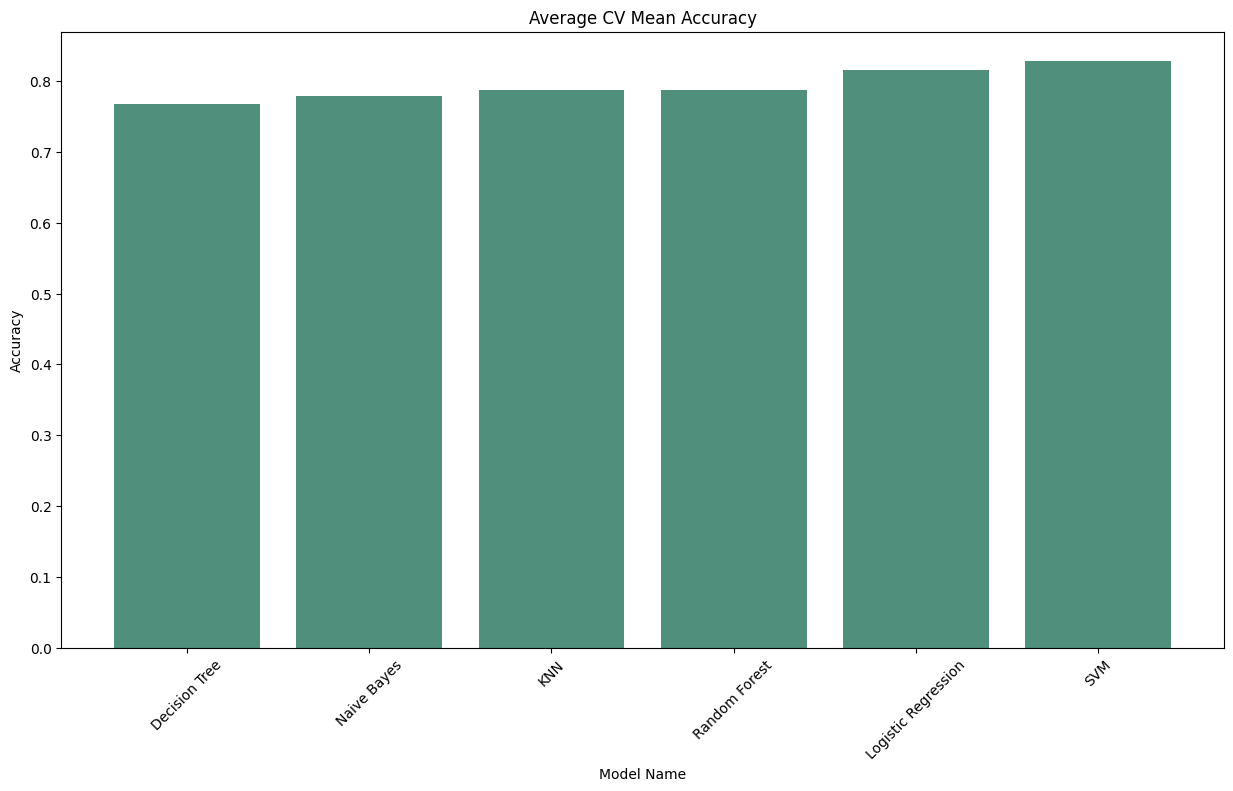

In [55]:
''' Plotting average cross validation accuracy for different models '''
plot_functions.plot_bar_plot(results["CV Accuracy Mean"])

I also plotted their confusion matrices but I will chose those 4 models for further hyperparameter tuning results.

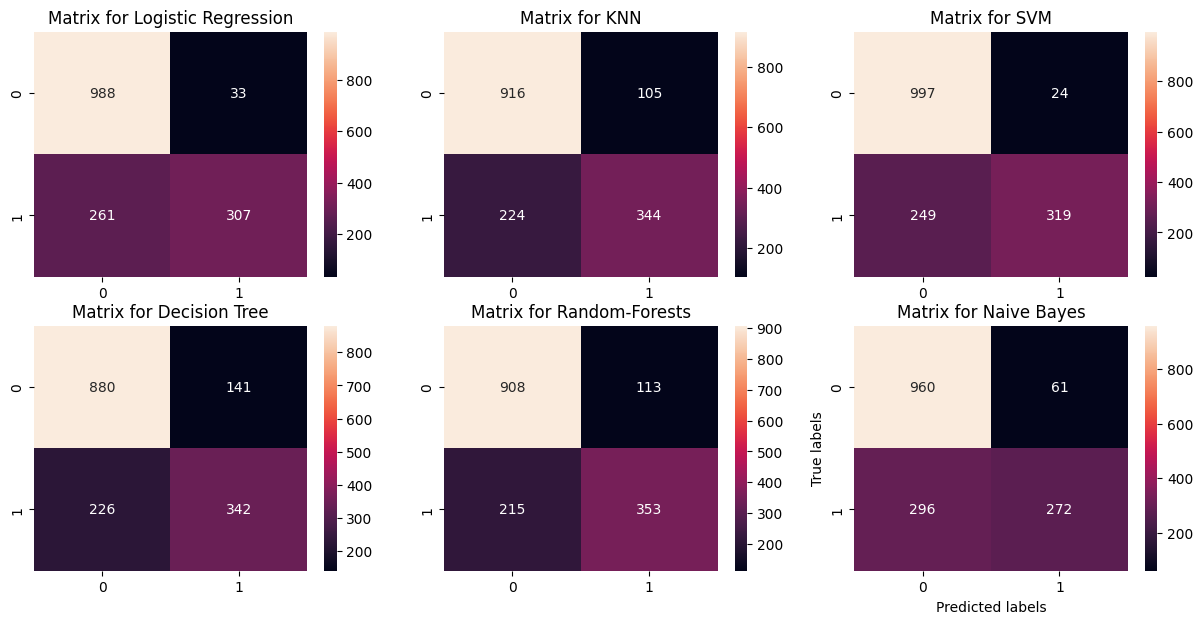

In [56]:
''' Plotting confusion matrices for different trained models  '''
f, ax = plt.subplots(2, 3, figsize=(15, 7))
plot_functions.plot_conf_matrix(
    LogisticRegression(), X_train, Y_train, "Logistic Regression", ax[0, 0]
)
plot_functions.plot_conf_matrix(
    KNeighborsClassifier(), X_train, Y_train, "KNN", ax[0, 1]
)
plot_functions.plot_conf_matrix(
    svm.SVC(probability=True), X_train, Y_train, "SVM", ax[0, 2]
)
plot_functions.plot_conf_matrix(
    DecisionTreeClassifier(), X_train, Y_train, "Decision Tree", ax[1, 0]
)
plot_functions.plot_conf_matrix(
    RandomForestClassifier(), X_train, Y_train, "Random-Forests", ax[1, 1]
)
plot_functions.plot_conf_matrix(GaussianNB(), X_train, Y_train, "Naive Bayes", ax[1, 2])
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

## <a id=prediction2>Prediction Phase with chosen best models</a>
* SVM
* Logistic Regression
* Random Forest
* KNN

### <a id=five1>Hyper-Parameters Tuning</a>

I will use grid search for hyper parameter tuning.

GridSearchCV is a technique for finding the optimal parameter values from a given set of parameters in a grid.

Then I perform grid search for all chosen models and compare their results.

#### <a id=five11>SVM</a>

In [57]:
''' Performing hyper parameter tuning with Grid Search for SVM model '''
C = [i / 100 for i in range(5, 105, 10)]
gamma = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
kernel = ["linear", "poly", "rbf"]

hyper = {"C": C, "gamma": gamma, "kernel": kernel}
grid_search = GridSearchCV(
    estimator=svm.SVC(probability=True), param_grid=hyper, verbose=True
)
grid_search.fit(X_train, Y_train)

print(grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
0.8294526119477016
SVC(C=0.15, gamma=0.3, kernel='poly', probability=True)


In [58]:
''' Taking best model from grid search '''
finalSVM = grid_search.best_estimator_

In [59]:
''' Printing out accuracy score for train and test data for SVM model '''
train_result = cross_val_score(finalSVM, X_train, Y_train, cv=10, scoring="accuracy")
print(
    "TRAIN DATA: The cross validated score for SVM Classifier is:", train_result.mean()
)
test_result = cross_val_score(finalSVM, X_test, Y_test, cv=10, scoring="accuracy")
final_test_SVM_result = finalSVM.predict(X_test)
print("TEST DATA: The cross validated score for SVM Classifier is:", test_result.mean())

TRAIN DATA: The cross validated score for SVM Classifier is: 0.8275535387309929
TEST DATA: The cross validated score for SVM Classifier is: 0.7991666666666666


#### <a id=five12>Logistic Regression</a>

In [60]:
''' Performing hyper parameter tuning with Grid Search for Logistic Regression model '''
solvers = ["newton-cg", "lbfgs", "liblinear"]
penalty = ["l2"]
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers, penalty=penalty, C=c_values)

grid_search = GridSearchCV(
    estimator=LogisticRegression(), param_grid=grid, verbose=True
)
grid_search.fit(X_train, Y_train)

print(grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
0.8156081979247267
LogisticRegression(C=100, solver='newton-cg')


In [61]:
''' Taking best Logistic Regressor model '''
finalLR = grid_search.best_estimator_

In [62]:
''' Printing out accuracy score for train and test data for Logistic Regression classifier '''
train_result = cross_val_score(finalLR, X_train, Y_train, cv=10, scoring="accuracy")
print(
    "TRAIN DATA: The cross validated score for Logistic Regression Classifier is:",
    train_result.mean(),
)
test_result = cross_val_score(finalLR, X_test, Y_test, cv=10, scoring="accuracy")
print(
    "TEST DATA: The cross validated score for Logistic Regression Classifier is:",
    test_result.mean(),
)

TRAIN DATA: The cross validated score for Logistic Regression Classifier is: 0.8155998726216065
TEST DATA: The cross validated score for Logistic Regression Classifier is: 0.771474358974359


#### <a id=five13>Random Forest Classifier</a>

In [63]:
''' Performing hyper parameter tuning with Grid Search for Random Forest Classifier model '''
n_estimators = range(100, 500, 100)  # number of trees in the random forest
max_depth = [
    1,
    5,
    10,
    15,
    20,
    25,
    30,
]  # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10]  # minimum sample number to split a node
min_samples_leaf = [1, 3, 4]  # minimum sample number that can be stored in a leaf node

hyper = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=0), param_grid=hyper, verbose=True
)
grid_search.fit(X_train, Y_train)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
0.8288256651389799
RandomForestClassifier(max_depth=10, min_samples_split=6, n_estimators=400,
                       random_state=0)


In [64]:
''' Taking best Random Forest model '''
finalRF = grid_search.best_estimator_

In [65]:
''' Printing out accuracy score for Random Forest Classifier best model '''
train_result = cross_val_score(finalRF, X_train, Y_train, cv=10, scoring="accuracy")
print(
    "TRAIN DATA: The cross validated score for Random Forest Classifier is:",
    train_result.mean(),
)
test_result = cross_val_score(finalRF, X_test, Y_test, cv=10, scoring="accuracy")
print(
    "TEST DATA: The cross validated score for Random Forest Classifier is:",
    test_result.mean(),
)

TRAIN DATA: The cross validated score for Random Forest Classifier is: 0.8275495581561978
TEST DATA: The cross validated score for Random Forest Classifier is: 0.7940384615384615


#### <a id=five14>KNN</a>

In [66]:
''' Performing hyper parameter tuning with Grid Search for K-nearest neighbors Classifier model '''
knn_params = {"n_neighbors": np.arange(1, 30, 1), "leaf_size": np.arange(30, 100, 5)}
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(), param_grid=knn_params, verbose=True
)
grid_search.fit(X_train, Y_train)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 406 candidates, totalling 2030 fits
0.8225304049362142
KNeighborsClassifier(n_neighbors=29)


In [67]:
''' Taking best K-nearest neighbors model '''
finalKNN = grid_search.best_estimator_

In [68]:
''' Printing out accuracy for train and test data with best KNN model '''
train_result = cross_val_score(finalKNN, X_train, Y_train, cv=10, scoring="accuracy")
print(
    "TRAIN DATA: The cross validated score for KNN Classifier is:", train_result.mean()
)
test_result = cross_val_score(finalKNN, X_test, Y_test, cv=10, scoring="accuracy")
print("TEST DATA: The cross validated score for KNN Classifier is:", test_result.mean())

TRAIN DATA: The cross validated score for KNN Classifier is: 0.8162367645888067
TEST DATA: The cross validated score for KNN Classifier is: 0.781602564102564


### <a id=five2>Model Evaluation</a>

After tuning hypter parameters for all different models, I will compare the results.

We can see that the selected models are better at performing people who did not buy travel insurance than those who did. Therefore, I will check their recall and precision values as well.

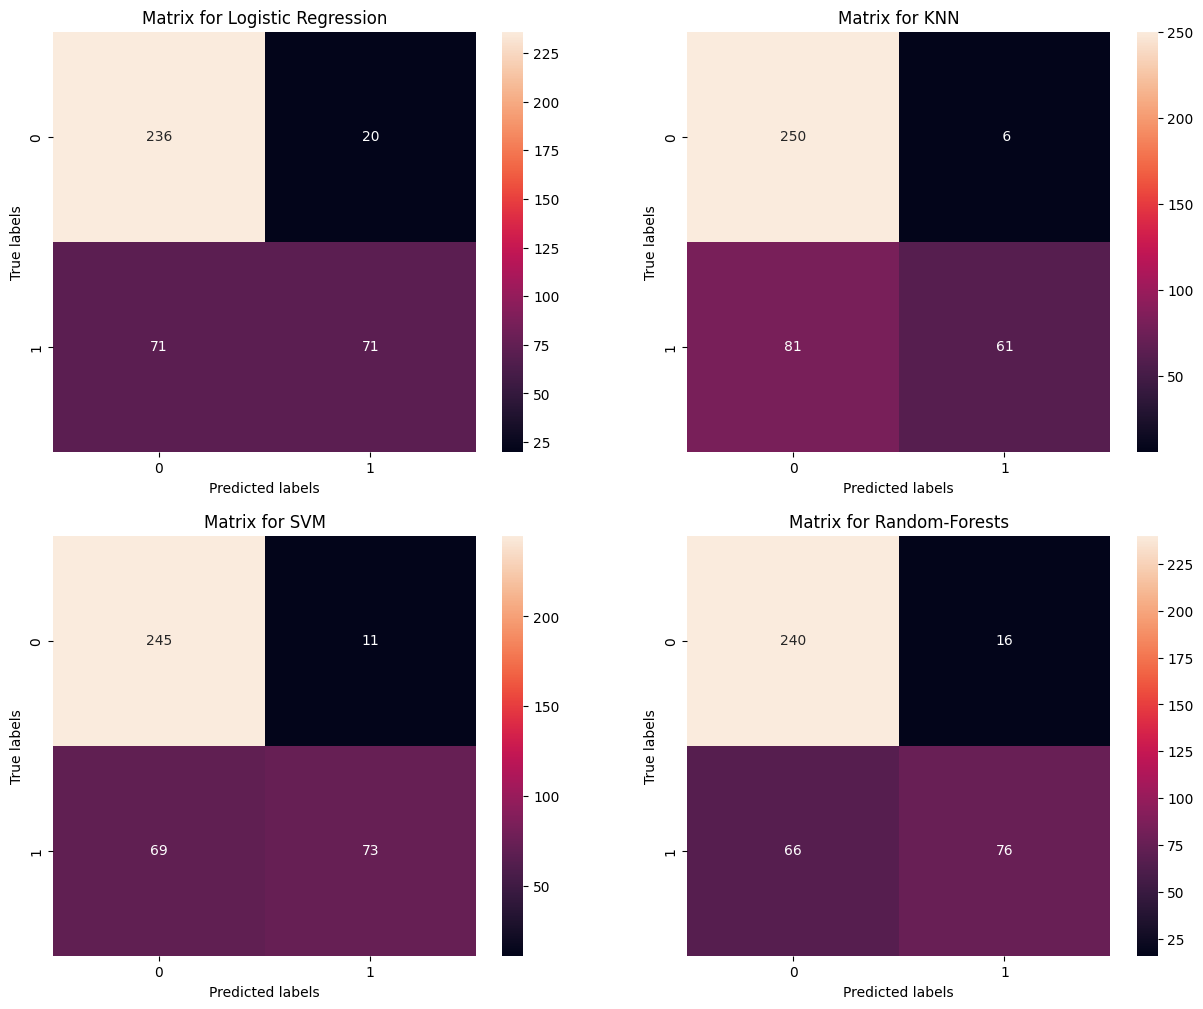

In [69]:
''' Plotting confussion matrices for final best models '''
result_comparison = plot_functions.plot_confusion_matrix_and_return_results(
    finalLR, finalKNN, finalSVM, finalRF, X_test, Y_test
)

In [70]:
''' Printing out accuracy, precision and recall for final models '''
result_comparison

,Accuracy,Precision,Recall
Logistic Regression,0.771357,0.780220,0.500000
KNN,0.781407,0.910448,0.429577
SVM,0.798995,0.869048,0.514085
Random Forest,0.793970,0.826087,0.535211


* We can see that the lowest precision and accuracy has Logistic Regression.
* The lowest recall has KNN but the highest precision.

SVM and Random Forest Classifier are similar in terms of accuracy but precision for SVM is way higher than RF even though it has a slighty higher recall. Therefore, for final predicition I choose SVM.

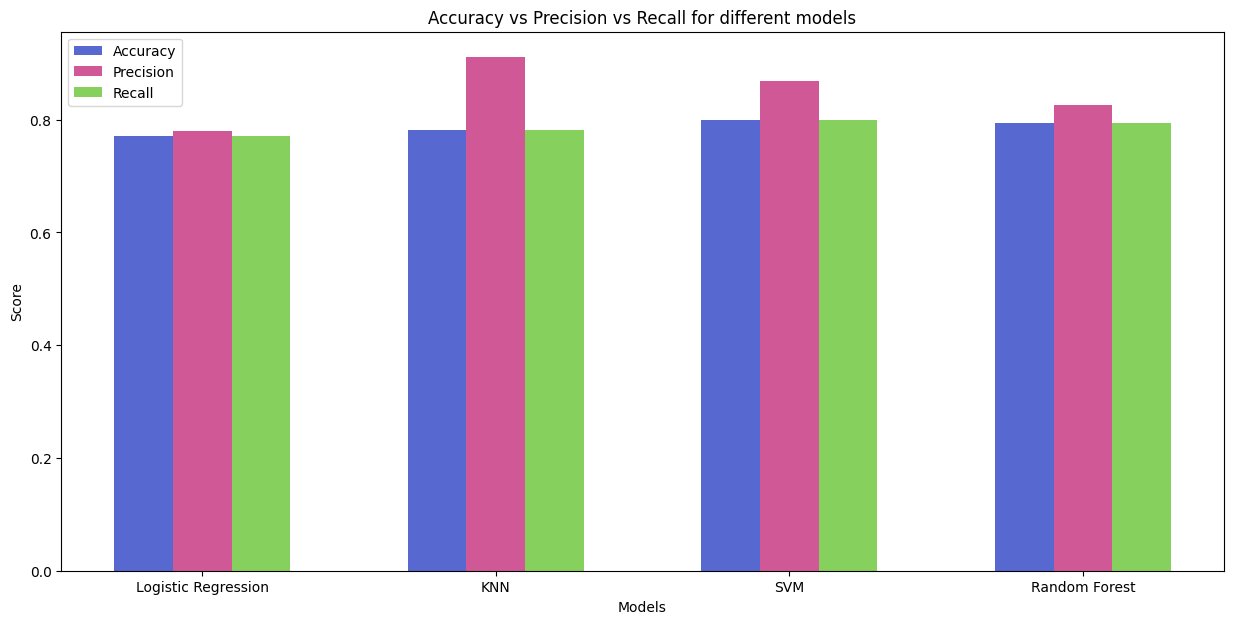

In [71]:
''' Plotting the results of these models - Accuracy, Precision, Recall '''
plot_functions.plot_model_comparison(result_comparison)

### <a id=five3>Final model SVM</a>

In order to evaluate the model, I will use ROC curve. 

The ROC curve shows the trade-off between sensitivity and specificity. Classifiers that give curves closer to the top-left corner indicate a better performance

We can see that for train data the AUC is higher which means that the model is slightly overfitting but the difference is not remarkable.

AUC for training data 0.8896776841263054
AUC for testing data 0.8056640625


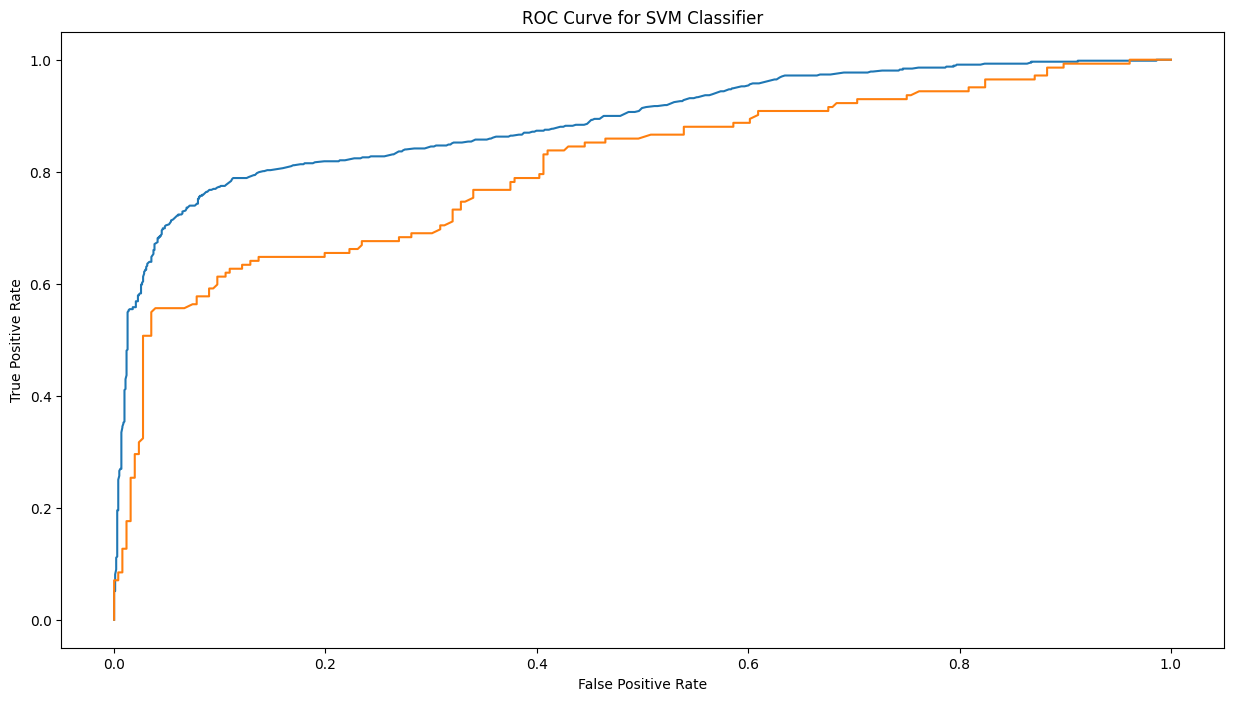

In [72]:
''' Plotting ROC curve for SVM Classifier '''
plot_functions.plot_roc_curve(
    finalSVM, X_train, Y_train, X_test, Y_test, "SVM Classifier"
)

To get better results for the model, I decided to perform bagging.

Bagging is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning models.

We can see a slight higher accuracy after performing bagging.

In [73]:
''' Performing bagging on SVM classifier '''
bagged_SVM = BaggingClassifier(finalSVM, n_estimators=50)
bagged_SVM.fit(X_train, Y_train)
bagged_SVM_test_pred = bagged_SVM.predict(X_test)

result = cross_val_score(bagged_SVM, X_train, Y_train, cv=10, scoring="accuracy")
print(
    "TRAIN DATA: The cross validated score for Bagged SVM Classifier is:", result.mean()
)

result = cross_val_score(bagged_SVM, X_test, Y_test, cv=10, scoring="accuracy")
print(
    "TEST DATA: The cross validated score for Bagged SVM Classifier is:", result.mean()
)

TRAIN DATA: The cross validated score for Bagged SVM Classifier is: 0.8256627657033675
TEST DATA: The cross validated score for Bagged SVM Classifier is: 0.8091025641025642


AUC for training data 0.8868635416810363
AUC for testing data 0.8052239216549295


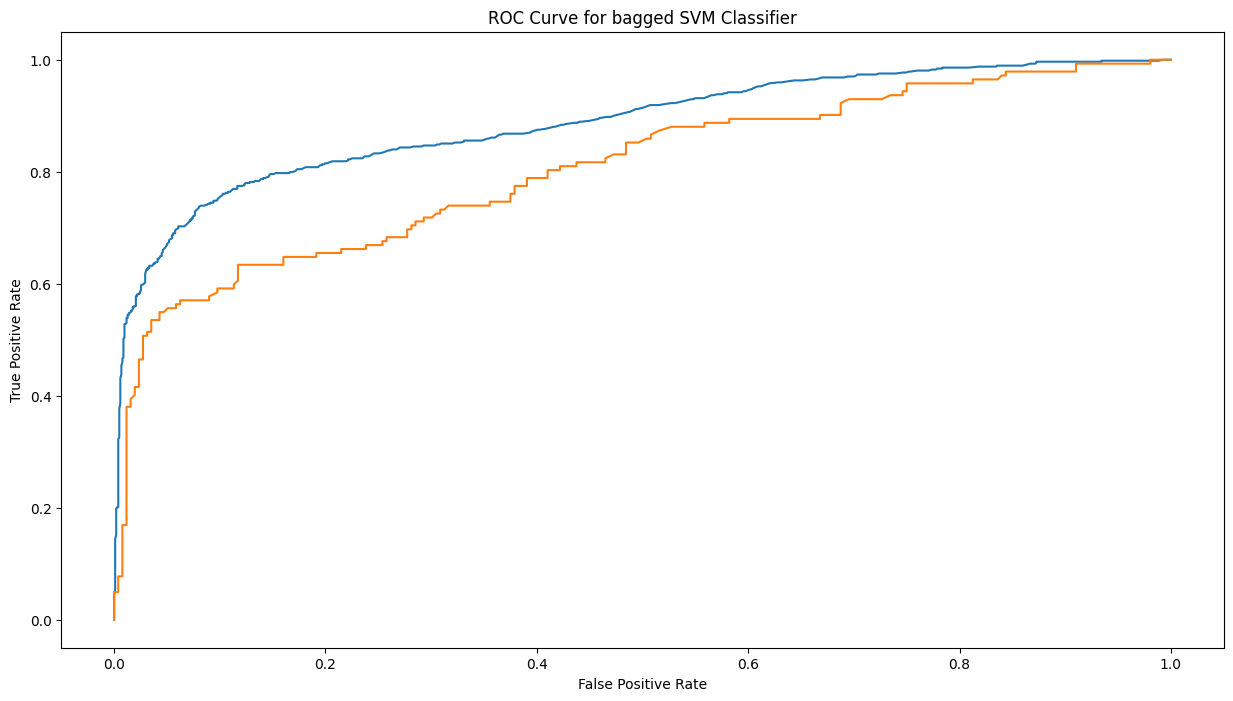

In [74]:
''' Plotting ROC curve for bagged SVM Classifier '''
plot_functions.plot_roc_curve(
    bagged_SVM, X_train, Y_train, X_test, Y_test, "bagged SVM Classifier"
)

Accuracy of Final SVM Model (not bagged) 0.804
Accuracy of Bagged SVM Model 0.807
Recall of Final SVM Model (not bagged) 0.514
Recall of Bagged SVM Model 0.521
Precision of Final SVM Model (not bagged) 0.89
Precision of Bagged SVM Model 0.892


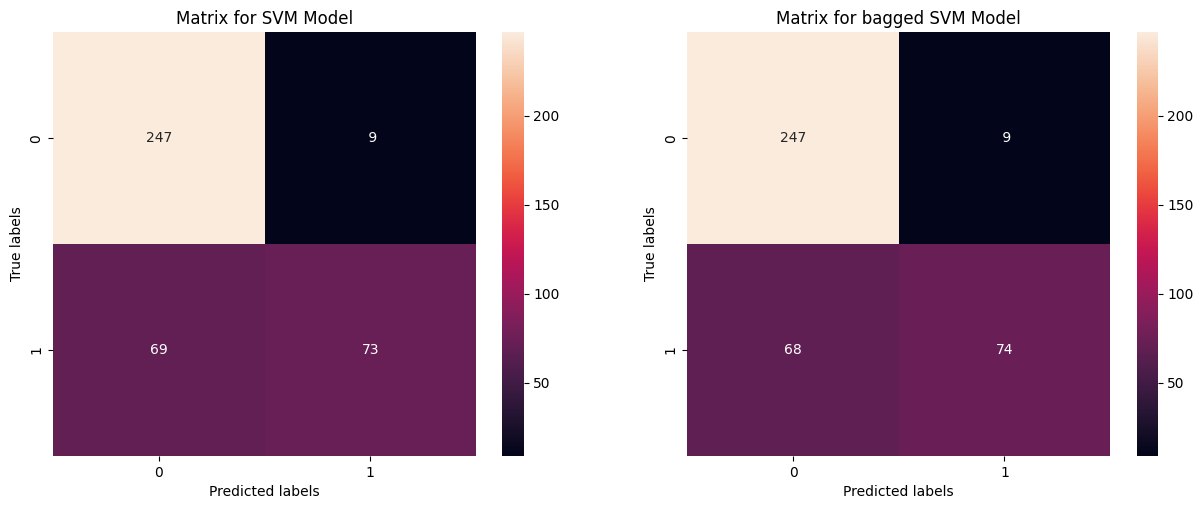

In [75]:
''' Plotting confussion matrix of bagged and not bagged SVM models '''
plot_functions.plot_confusion_matrix_and_print_results(
    final_test_SVM_result, bagged_SVM_test_pred, Y_test, "SVM Model"
)

### <a id=five4>Final Model Evaluation</a>


In [73]:
explainer = shap.Explainer(bagged_SVM.predict, X_test.head(150))
shap_values = explainer(X_test.head(150))

Permutation explainer: 151it [31:40, 12.76s/it]                          


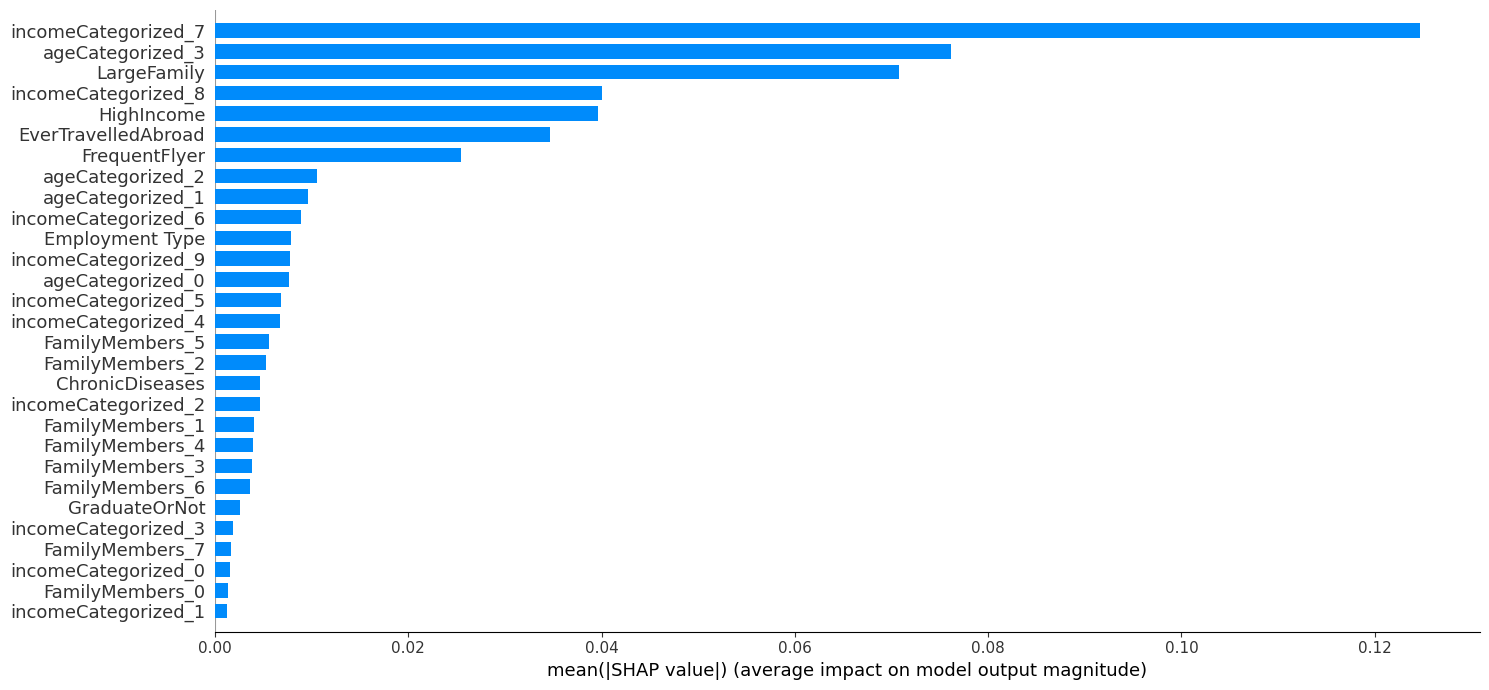

In [74]:
shap.summary_plot(shap_values, max_display=30, show=False, plot_type='bar', plot_size=[15,7])

## <a id=summary>Summary</a>

All in all, in this project the analysis has been conducted on TravelInsurancePrediction.csv data. After the analysis part, prediction phase has been conducted which tested 6 different classification models. After training these 6 models, only 4 were selected for further hyper parameter tuning and after checking their results the final model has been selected - SVC(C=0.15, gamma=0.3, kernel='poly').

Bagging classification has been applied to the final SVM model. In bagging, each individual SVM is trained independently using the randomly chosen training samples via a bootstrap technique. This bagged final SVM model had these results:

* Accuracy - 0.8065 
* Precision - 0.8915 
* Recall - 0.5211 

The model was overfitting a bit which can be seen in the ROC curve plot. But overall, it is better at prediction people who did not buy travel insurance rather than ones who did. This might be that there is more data of people who bought travel insurance than who did not. Thus, it considered people who bought travel insurance as the ones who did not more othen than the ones who did not and were considered as people who bought.

However, the dataset is too small to make it more equal of both classes (people who bought and did not), therefore, the predictions might be correct only for this particular scenario rather than the real situation.

The features that had the strongest correlation with the target value TravelInsurance were:
* EverTravelledAbroad
* AnnualIncome 
* FrequentFlyer

Features that did not have huge impact on predicting TravelInsurance:
* ChronicDiseases
* GraduateOrNot


## <a id=future_imp>Future Improvements</a>

* Removing features which do not have meaningful correlation.
* Using pipelines
* Doing more hypothesis testing to get better results
* Try using more classification models
* Test edge cases for False negatives and False Positives and False negatives.